# Начало

In [ ]:
#УСТАНОВКА ЗАВИСИМОСТЕЙ

!pip install -q openai gradio tiktoken langchain langchain-openai langchain-community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:0

In [ ]:
# ИМПОРТЫ

import os
import shutil
import ast
import json
import logging
import pandas as pd
import gradio as gr
import tiktoken
from typing import List, Dict, Any, Optional, Tuple
from datetime import datetime
from io import StringIO

#Google Colab
from google.colab import auth, drive, files
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

#LangChain
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.schema import Document

In [ ]:
# НАСТРОЙКА ЛОГИРОВАНИЯ

class LogHandler:
    """Обработчик логов для отображения в интерфейсе"""

    def __init__(self):
        self.logs = []
        self.setup_logging()

    def setup_logging(self):
        """Настройка системы логирования"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[logging.StreamHandler()]
        )
        self.logger = logging.getLogger(__name__)

    def log(self, message: str, level: str = "INFO"):
        """Добавление лога"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = f"[{timestamp}] {level}: {message}"
        self.logs.append(log_entry)

        if level == "ERROR":
            self.logger.error(message)
        elif level == "WARNING":
            self.logger.warning(message)
        else:
            self.logger.info(message)

    def get_logs(self) -> str:
        """Получение всех логов"""
        return "\n".join(self.logs[-50:])  # Последние 50 записей

    def clear_logs(self):
        """Очистка логов"""
        self.logs.clear()

# МОДУЛЬ РАБОТЫ С GOOGLE COLAB API

class ColabNotebookManager:
    """Менеджер для работы с ноутбуками Google Colab"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler
        self.service = None
        self.user_email = None

    def authenticate(self) -> bool:
        """Аутентификация в Google API"""
        try:
            self.log_handler.log("Начало аутентификации в Google API")
            auth.authenticate_user()
            self.service = build('drive', 'v3')

            # Получаем email пользователя
            about = self.service.about().get(fields='user').execute()
            self.user_email = about['user']['emailAddress']

            self.log_handler.log(f"Аутентификация успешна. Пользователь: {self.user_email}")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка аутентификации: {str(e)}", "ERROR")
            return False

    def get_notebooks(self) -> List[Dict[str, Any]]:
        notebooks = []
        if not self.service:
            self.log_handler.log("Сервис не инициализирован, вызовите authenticate()")
            return notebooks

        query = "(mimeType='application/vnd.google.colaboratory' or mimeType='application/x-ipynb+json')"
        page_token = None

        while True:
            try:
                response = self.service.files().list(
                    q=query,
                    fields="nextPageToken, files(id, name, webViewLink, owners)",
                    pageToken=page_token
                ).execute()
            except HttpError as e:
                self.log_handler.log(f"Ошибка запроса к Drive API: {e}")
                break

            files = response.get('files', [])
            for file in files:
                # Ваша текущая фильтрация по имени и владельцу
                if "untitled" in file['name'].lower():
                    continue
                owners = file.get('owners', [])
                if not any(owner.get('emailAddress', '') == self.user_email for owner in owners):
                    continue

                notebooks.append({
                    "id": file['id'],
                    "name": file['name'],
                    "link": file.get('webViewLink', '')
                })

            page_token = response.get('nextPageToken')
            if not page_token:
                break

        self.log_handler.log(f"Найдено ноутбуков: {len(notebooks)}")
        return notebooks

    def get_notebook_content(self, notebook_id: str) -> Optional[Dict]:
        """Получение содержимого ноутбука в формате JSON"""
        try:
            self.log_handler.log(f"Загрузка содержимого ноутбука {notebook_id}")

            file_metadata = self.service.files().get(fileId=notebook_id, fields='mimeType').execute()
            mime_type = file_metadata.get('mimeType')

            # Для Google Colab и обычных ipynb файлов — скачиваем через get_media
            if mime_type in ['application/vnd.google.colaboratory', 'application/ipynb+json', 'application/json', 'application/octet-stream']:
                request = self.service.files().get_media(fileId=notebook_id)
                fh = io.BytesIO()
                downloader = MediaIoBaseDownload(fh, request)

                done = False
                while not done:
                    status, done = downloader.next_chunk()

                content = fh.getvalue().decode('utf-8')
                return json.loads(content)

            # Если вдруг файл Google Docs и поддерживает экспорт — экспортируем в json (редкий случай)
            elif mime_type in ['application/vnd.google-apps.document',
                               'application/vnd.google-apps.spreadsheet',
                               'application/vnd.google-apps.presentation']:
                export_mime = 'application/json'  # Или другой подходящий mimeType для экспорта
                content = self.service.files().export(fileId=notebook_id, mimeType=export_mime).execute()
                return json.loads(content.decode('utf-8'))

            else:
                self.log_handler.log(f"Неподдерживаемый mimeType файла {mime_type} для ноутбука {notebook_id}", "WARNING")
                return None

        except HttpError as e:
            if e.resp.status == 403:
                self.log_handler.log(f"Нет доступа к ноутбуку {notebook_id}, пропускаем", "WARNING")
            else:
                self.log_handler.log(f"HTTP ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None
        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None

# МОДУЛЬ АНАЛИЗА КОДА

class CodeAnalyzer:
    """Анализатор кода Python"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler

    def extract_imports(self, code: str) -> List[str]:
        """Извлечение импортов из кода"""
        try:
            tree = ast.parse(code)
            imports = []

            for node in ast.walk(tree):
                if isinstance(node, ast.Import):
                    for alias in node.names:
                        imports.append(alias.name)
                elif isinstance(node, ast.ImportFrom):
                    module = node.module or ''
                    for alias in node.names:
                        imports.append(f"{module}.{alias.name}" if module else alias.name)

            return list(set(imports))

        except SyntaxError:
            return []
        except Exception as e:
            self.log_handler.log(f"Ошибка анализа импортов: {str(e)}", "WARNING")
            return []

    def extract_functions_and_classes(self, code: str) -> Dict[str, List[Dict]]:
        """Извлечение функций и классов из кода"""
        try:
            tree = ast.parse(code)
            functions = []
            classes = []

            # Сначала найдем все классы для проверки вложенности
            class_nodes = [node for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]

            for node in ast.walk(tree):
                if isinstance(node, ast.FunctionDef):
                    # Проверяем, что функция не внутри класса
                    is_inside_class = False
                    for class_node in class_nodes:
                        if node in class_node.body:
                            is_inside_class = True
                            break

                    if not is_inside_class:
                        try:
                            functions.append({
                                'name': node.name,
                                'code': ast.unparse(node) if hasattr(ast, 'unparse') else f"def {node.name}(...): ...",
                                'type': 'function'
                            })
                        except:
                            functions.append({
                                'name': node.name,
                                'code': f"def {node.name}(...): ...",
                                'type': 'function'
                            })

                elif isinstance(node, ast.ClassDef):
                    methods = []
                    for item in node.body:
                        if isinstance(item, ast.FunctionDef):
                            try:
                                methods.append({
                                    'name': item.name,
                                    'code': ast.unparse(item) if hasattr(ast, 'unparse') else f"def {item.name}(...): ...",
                                    'type': 'method'
                                })
                            except:
                                methods.append({
                                    'name': item.name,
                                    'code': f"def {item.name}(...): ...",
                                    'type': 'method'
                                })

                    try:
                        class_code = ast.unparse(node) if hasattr(ast, 'unparse') else f"class {node.name}: ..."
                    except:
                        class_code = f"class {node.name}: ..."

                    classes.append({
                        'name': node.name,
                        'code': class_code,
                        'methods': methods,
                        'type': 'class'
                    })

            return {'functions': functions, 'classes': classes}

        except SyntaxError:
            return {'functions': [], 'classes': []}
        except Exception as e:
            self.log_handler.log(f"Ошибка анализа функций и классов: {str(e)}", "WARNING")
            return {'functions': [], 'classes': []}

# МОДУЛЬ ОБРАБОТКИ НОУТБУКОВ

class NotebookProcessor:
    """Процессор для анализа ноутбуков"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler
        self.code_analyzer = CodeAnalyzer(log_handler)

    def extract_headers(self, cells: List[Dict]) -> List[str]:
        """Извлечение заголовков из ячеек markdown"""
        headers = []

        for cell in cells:
            if cell.get('cell_type') == 'markdown':
                source = ''.join(cell.get('source', []))
                lines = source.split('\n')

                for line in lines:
                    line = line.strip()
                    if line.startswith('#'):
                        # Очистка заголовка от лишних символов
                        header = line.lstrip('#').strip()
                        if header:
                            headers.append(header)

        return headers

    def extract_conclusion(self, cells: List[Dict]) -> str:
        """Извлечение текста после заголовка 'Итог'"""
        conclusion_found = False
        conclusion_text = []

        for cell in cells:
            if cell.get('cell_type') == 'markdown':
                source = ''.join(cell.get('source', []))
                lines = source.split('\n')

                for line in lines:
                    line_clean = line.strip().lower()
                    if line_clean.startswith('#') and 'итог' in line_clean:
                        conclusion_found = True
                        continue

                    if conclusion_found:
                        if line.strip().startswith('#'):
                            # Новый заголовок - прекращаем сбор
                            break
                        conclusion_text.append(line)

        result = '\n'.join(conclusion_text).strip()
        return result if result else "Нет итога"

    def extract_code_elements(self, cells: List[Dict]) -> Tuple[List[str], Dict]:
        """Извлечение импортов, функций и классов из кода"""
        all_imports = []
        all_code_elements = {'functions': [], 'classes': []}

        for cell in cells:
            if cell.get('cell_type') == 'code':
                source = ''.join(cell.get('source', []))

                # Очистка от магических команд
                lines = source.split('\n')
                clean_lines = []
                for line in lines:
                    if not line.strip().startswith(('!', '%', '?')):
                        clean_lines.append(line)

                clean_code = '\n'.join(clean_lines)

                if clean_code.strip():
                    # Извлечение импортов
                    imports = self.code_analyzer.extract_imports(clean_code)
                    all_imports.extend(imports)

                    # Извлечение функций и классов
                    code_elements = self.code_analyzer.extract_functions_and_classes(clean_code)
                    all_code_elements['functions'].extend(code_elements['functions'])
                    all_code_elements['classes'].extend(code_elements['classes'])

        return list(set(all_imports)), all_code_elements

    def process_notebook(self, notebook_data: Dict, notebook_info: Dict) -> Dict:
        """Обработка одного ноутбука"""
        try:
            self.log_handler.log(f"Обработка ноутбука: {notebook_info['name']}")

            cells = notebook_data.get('cells', [])

            # Извлечение данных
            headers = self.extract_headers(cells)
            conclusion = self.extract_conclusion(cells)
            imports, code_elements = self.extract_code_elements(cells)

            # Формирование списка функций и классов
            functions_and_classes = []
            for func in code_elements['functions']:
                functions_and_classes.append(f"Функция: {func['name']}")
            for cls in code_elements['classes']:
                functions_and_classes.append(f"Класс: {cls['name']}")

            result = {
                'ссылка': notebook_info['link'],
                'название': notebook_info['name'],
                'заголовки': '; '.join(headers) if headers else 'нет заголовков',
                'библиотеки': ', '.join(imports) if imports else 'нет импортов',
                'классы и функции': '; '.join(functions_and_classes) if functions_and_classes else 'нет функций',
                'описание': '',  # Будет заполнено LLM
                'итог': conclusion,
                'code_elements': code_elements  # Для передачи в LLM
            }

            self.log_handler.log(f"Ноутбук {notebook_info['name']} обработан успешно")
            return result

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки ноутбука {notebook_info['name']}: {str(e)}", "ERROR")
            return None

# МОДУЛЬ РАБОТЫ С LLM

class LLMProcessor:
    """Процессор для работы с языковой моделью"""

    def __init__(self, api_key: str, endpoint: str, log_handler: LogHandler):
        self.log_handler = log_handler
        self.llm = ChatOpenAI(
            openai_api_key=api_key,
            openai_api_base=endpoint,
            temperature=0.3,
            model_name="gpt-4.1-nano"
        )
        self.encoding = tiktoken.get_encoding("cl100k_base")

    def count_tokens(self, text: str) -> int:
        """Подсчет токенов в тексте"""
        return len(self.encoding.encode(text))

    def describe_code_element(self, element: Dict) -> str:
        """Получение описания элемента кода от LLM"""
        try:
            element_type = element.get('type', 'function')
            element_name = element.get('name', 'unknown')
            element_code = element.get('code', '')

            prompt = f"""
Проанализируй следующий код {element_type} '{element_name}' и опиши его в формате:

{element_name}
Логическая задача
Краткое описание способа выполнения задачи

Код:
python
{element_code}

Ответ должен быть структурированным и кратким.
"""

            response = self.llm.invoke(prompt)
            self.log_handler.log(f"Получено описание для {element_type} {element_name}")

            return response.content.strip()

        except Exception as e:
            self.log_handler.log(f"Ошибка получения описания от LLM: {str(e)}", "ERROR")
            return f"Ошибка описания {element.get('name', 'unknown')}"

    def describe_class_with_methods(self, class_element: Dict) -> str:
        """Получение описания класса с методами"""
        try:
            class_name = class_element.get('name', 'unknown')
            methods = class_element.get('methods', [])

            # Сначала получаем описания методов
            method_descriptions = []
            for method in methods:
                method_desc = self.describe_code_element(method)
                method_descriptions.append(method_desc)

            # Затем описываем весь класс
            methods_summary = '\n'.join([f"- {method['name']}" for method in methods])

            prompt = f"""
Проанализируй класс '{class_name}' с методами и опиши его в формате:

{class_name}
Логическая задача
Краткое описание способа выполнения задачи

Методы класса:
{methods_summary}

Описания методов:
{chr(10).join(method_descriptions)}

Дай общее описание класса и его назначения.
"""

            response = self.llm.invoke(prompt)
            self.log_handler.log(f"Получено описание для класса {class_name}")

            return response.content.strip()

        except Exception as e:
            self.log_handler.log(f"Ошибка получения описания класса от LLM: {str(e)}", "ERROR")
            return f"Ошибка описания класса {class_element.get('name', 'unknown')}"

    def process_notebook_descriptions(self, notebook_data: Dict) -> str:
        """Обработка всех элементов кода в ноутбуке"""
        try:
            code_elements = notebook_data.get('code_elements', {'functions': [], 'classes': []})
            descriptions = []

            # Обработка функций
            for function in code_elements['functions']:
                desc = self.describe_code_element(function)
                descriptions.append(desc)

            # Обработка классов
            for class_element in code_elements['classes']:
                desc = self.describe_class_with_methods(class_element)
                descriptions.append(desc)

            return '\n\n'.join(descriptions) if descriptions else 'Нет описаний'

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки описаний: {str(e)}", "ERROR")
            return 'Ошибка обработки описаний'

# МОДУЛЬ РАБОТЫ С ВЕКТОРНОЙ БАЗОЙ

class ChromaManager:
    """Менеджер для работы с векторной базой Chroma"""

    def __init__(self, api_key: str, endpoint: str, log_handler: LogHandler):
        self.log_handler = log_handler

        # ИЗМЕНЕНО: добавлен endpoint для embeddings
        self.embeddings = OpenAIEmbeddings(
            openai_api_key=api_key,
            openai_api_base=endpoint,
            model="text-embedding-3-small"  # ИЗМЕНЕНО: используем text-embedding-3-small
        )

        self.vectorstore = None
        self.qa_chain = None
        self.api_key = api_key
        self.endpoint = endpoint

        # ИЗМЕНЕНО: используем cl100k_base токенизатор
        self.encoding = tiktoken.get_encoding("cl100k_base")

    def create_vectorstore(self, df: pd.DataFrame) -> bool:
        """Создание векторной базы из датафрейма"""
        try:
            self.log_handler.log("Создание векторной базы Chroma")

            documents = []
            metadatas = []

            for _, row in df.iterrows():
                # Документы для Chroma (текстовые данные)
                doc_content = f"""
Название: {row['название']}
Заголовки: {row['заголовки']}
Описание: {row['описание']}
Итог: {row['итог']}
"""

                # Метаданные для Chroma
                metadata = {
                    'ссылка': row['ссылка'],
                    'библиотеки': row['библиотеки'],
                    'классы и функции': row['классы и функции']
                }

                documents.append(Document(page_content=doc_content, metadata=metadata))

            # Создание векторной базы
            self.vectorstore = Chroma.from_documents(
                documents=documents,
                embedding=self.embeddings,
                persist_directory="./chroma_db"
            )

            # Исоздание QA цепочки с ChatOpenAI
            self.qa_chain = RetrievalQA.from_chain_type(
                llm=ChatOpenAI(
                    openai_api_key=self.api_key,
                    openai_api_base=self.endpoint,
                    temperature=0.3,
                    model_name="gpt-4.1-nano"
                ),
                chain_type="stuff",
                retriever=self.vectorstore.as_retriever(search_kwargs={"k": 3}),
                return_source_documents=True
            )

            self.log_handler.log(f"Векторная база создана с {len(documents)} документами")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка создания векторной базы: {str(e)}", "ERROR")
            return False

    def query(self, question: str) -> Tuple[str, int, List[str]]:
        """Запрос к векторной базе"""
        try:
            if not self.qa_chain:
                return "Векторная база не создана", 0, []

            self.log_handler.log(f"Обработка запроса: {question}")

            # Подсчет токенов в запросе
            input_tokens = len(self.encoding.encode(question))

            # Выполнение запроса
            result = self.qa_chain({"query": question})

            # Подсчет токенов в ответе
            output_tokens = len(self.encoding.encode(result['result']))
            total_tokens = input_tokens + output_tokens

            # Извлечение ссылок из источников
            links = []
            for doc in result.get('source_documents', []):
                link = doc.metadata.get('ссылка')
                if link and link not in links:
                    links.append(link)

            self.log_handler.log(f"Запрос обработан. Использовано токенов: {total_tokens}")

            return result['result'], total_tokens, links

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", 0, []

# ГЛАВНЫЙ КЛАСС ПРИЛОЖЕНИЯ

class NotebookAssistant:
    """Главный класс ассистента обработки ноутбуков"""

    def __init__(self):
        self.log_handler = LogHandler()
        self.colab_manager = ColabNotebookManager(self.log_handler)
        self.notebook_processor = NotebookProcessor(self.log_handler)
        self.llm_processor = None
        self.chroma_manager = None
        self.df = None
        self.api_key = None
        self.endpoint = None

    def set_api_key(self, api_key: str, endpoint: str) -> str:
        """Установка API ключа и endpoint OpenAI"""
        try:
            self.api_key = api_key
            self.endpoint = endpoint
            self.llm_processor = LLMProcessor(api_key, endpoint, self.log_handler)
            self.chroma_manager = ChromaManager(api_key, endpoint, self.log_handler)
            self.log_handler.log("API ключ и endpoint установлены успешно")
            return "API ключ и endpoint установлены успешно"
        except Exception as e:
            self.log_handler.log(f"Ошибка установки API ключа: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    def get_data(self) -> Tuple[str, str]:
        """Получение и обработка данных из ноутбуков"""
        try:
            if not self.api_key:
                return "Сначала установите API ключ OpenAI", self.log_handler.get_logs()

            self.log_handler.clear_logs()
            self.log_handler.log("Начало обработки ноутбуков")

            # Аутентификация
            if not self.colab_manager.authenticate():
                return "Ошибка аутентификации", self.log_handler.get_logs()

            # Получение ноутбуков
            notebooks = self.colab_manager.get_notebooks()
            if not notebooks:
                return "Подходящие ноутбуки не найдены", self.log_handler.get_logs()

            # Обработка ноутбуков
            processed_data = []
            for notebook in notebooks:
                self.log_handler.log(f"Загрузка ноутбука: {notebook['name']}")

                notebook_content = self.colab_manager.get_notebook_content(notebook['id'])
                if notebook_content:
                    processed_notebook = self.notebook_processor.process_notebook(
                        notebook_content, notebook
                    )

                    if processed_notebook:
                        # Получение описаний от LLM
                        self.log_handler.log(f"Получение описаний от LLM для: {notebook['name']}")
                        description = self.llm_processor.process_notebook_descriptions(processed_notebook)
                        processed_notebook['описание'] = description

                        # Удаляем временные данные
                        del processed_notebook['code_elements']
                        processed_data.append(processed_notebook)

            # Создание датафрейма
            self.df = pd.DataFrame(processed_data)

            self.log_handler.log(f"Обработка завершена. Создан датафрейм с {len(self.df)} записями")

            return f"Успешно обработано {len(self.df)} ноутбуков", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Критическая ошибка: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    def download_dataframe(self) -> Tuple[str, Optional[str]]:
        """Скачивание датафрейма"""
        try:
            if self.df is None:
                return "Сначала получите данные", None

            filename = f"notebooks_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            filepath = f"/content/{filename}"
            self.df.to_csv(filepath, index=False, encoding='utf-8')

            self.log_handler.log(f"Датафрейм сохранен: {filename}")
            return f"Файл {filename} готов к скачиванию", filepath

        except Exception as e:
            self.log_handler.log(f"Ошибка скачивания: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", None

    def load_dataframe(self, file_path: str) -> str:
        """Загрузка датафрейма из файла"""
        try:
            if not file_path:
                return "Файл не выбран"

            self.df = pd.read_csv(file_path, encoding='utf-8')
            self.log_handler.log(f"Датафрейм загружен из {file_path}")
            return f"Датафрейм загружен успешно. Записей: {len(self.df)}"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки датафрейма: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    def save_vectorstore(self) -> str:
        """Сохранение векторной базы"""
        try:
            if not self.chroma_manager or not self.chroma_manager.vectorstore:
                return "Векторная база не создана"

            # Chroma автоматически сохраняется в persist_directory
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            backup_dir = f"/content/chroma_backup_{timestamp}"

            import shutil
            shutil.copytree("./chroma_db", backup_dir)

            self.log_handler.log(f"Векторная база сохранена в {backup_dir}")
            return f"База сохранена в {backup_dir}"

        except Exception as e:
            self.log_handler.log(f"Ошибка сохранения базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    def load_vectorstore(self, backup_dir: str) -> str:
        """Загрузка векторной базы"""
        try:
            if not backup_dir:
                return "Папка не выбрана"

            if not self.chroma_manager:
                return "Сначала установите API ключ"

            # Удаляем старую базу если есть
            if os.path.exists("./chroma_db"):
                shutil.rmtree("./chroma_db")

            # Копируем загруженную базу
            shutil.copytree(backup_dir, "./chroma_db")

            # Переинициализируем векторную базу
            self.chroma_manager.vectorstore = Chroma(
                persist_directory="./chroma_db",
                embedding_function=self.chroma_manager.embeddings
            )

            # Создание QA цепочки
            from langchain_openai import ChatOpenAI
            self.chroma_manager.qa_chain = RetrievalQA.from_chain_type(
                llm=ChatOpenAI(
                    openai_api_key=self.chroma_manager.api_key,
                    openai_api_base=self.chroma_manager.endpoint,
                    temperature=0.3,
                    model_name="gpt-4.1-nano"
                ),
                chain_type="stuff",
                retriever=self.chroma_manager.vectorstore.as_retriever(search_kwargs={"k": 3}),
                return_source_documents=True
            )

            self.log_handler.log(f"Векторная база загружена из {backup_dir}")
            return "База загружена успешно"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"


    def create_vectorstore(self) -> Tuple[str, str]:
        """Создание векторной базы"""
        try:
            if self.df is None:
                return "Сначала получите данные", self.log_handler.get_logs()

            if not self.chroma_manager:
                return "API ключ не установлен", self.log_handler.get_logs()

            success = self.chroma_manager.create_vectorstore(self.df)

            if success:
                return "Векторная база создана успешно", self.log_handler.get_logs()
            else:
                return "Ошибка создания векторной базы", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка создания базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    def query_assistant(self, question: str) -> Tuple[str, str, str]:
        """Запрос к ассистенту"""
        try:
            if not self.chroma_manager or not self.chroma_manager.qa_chain:
                return "Векторная база не создана", "", self.log_handler.get_logs()

            answer, tokens, links = self.chroma_manager.query(question)

            # Форматирование ответа
            response = f"{answer}\n\n"
            if links:
                response += "Ссылки на ноутбуки:\n"
                for i, link in enumerate(links, 1):
                    response += f"{i}. {link}\n"

            token_info = f"Использовано токенов: {tokens}"

            return response, token_info, self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", "", self.log_handler.get_logs()

# ИНТЕРФЕЙС GRADIO

def create_interface():
    """Создание интерфейса Gradio"""

    assistant = NotebookAssistant()

    with gr.Blocks(title="Локальный Ассистент обработки ноутбуков CoLAN/n(Colab Local ANalyzer)") as interface:
        gr.Markdown("# 🤖 Локальный Ассистент обработки ноутбуков CoLAN/n(Colab Local ANalyzer)")
        gr.Markdown("Анализирует ваши ноутбуки и создает векторную базу для поиска")

        with gr.Tab("⚙️ Настройка"):
            model_input = gr.Textbox(
                label="Модель HuggingFace",
                value="meta-llama/Llama-3.1-8B",
                placeholder="meta-llama/Llama-3.1-8B"
            )
            model_btn = gr.Button("Загрузить модель")
            model_output = gr.Textbox(label="Статус", interactive=False)

            model_btn.click(
                assistant.set_model,
                inputs=[model_input],
                outputs=[model_output]
            )

        with gr.Tab("📊 Обработка данных"):
            with gr.Row():
                get_data_btn = gr.Button("Получить данные", variant="primary")
                create_db_btn = gr.Button("Создать базу", variant="secondary")

            with gr.Row():
                with gr.Column():
                    gr.Markdown("### Датафрейм")
                    download_btn = gr.Button("Скачать датафрейм")
                    download_file = gr.File(label="Скачать файл", visible=False)
                    upload_df = gr.File(label="Загрузить датафрейм (.csv)", file_types=[".csv"])
                    load_df_btn = gr.Button("Загрузить датафрейм")

                with gr.Column():
                    gr.Markdown("### Векторная база")
                    save_db_btn = gr.Button("Сохранить базу")
                    upload_db = gr.File(label="Загрузить базу (папка)", file_count="directory")
                    load_db_btn = gr.Button("Загрузить базу")

            status_output = gr.Textbox(label="Статус операции", interactive=False)
            logs_output = gr.Textbox(
                label="Логи выполнения",
                lines=10,
                interactive=False
            )

            # Обработчики событий
            get_data_btn.click(
                assistant.get_data,
                outputs=[status_output, logs_output]
            )

            def handle_download(assistant_ref):
                status, filepath = assistant_ref.download_dataframe()
                if filepath:
                    return status, gr.update(value=filepath, visible=True)
                return status, gr.update(visible=False)

            download_btn.click(
                lambda: handle_download(assistant),
                outputs=[status_output, download_file]
            )

            load_df_btn.click(
                lambda file: assistant.load_dataframe(file.name if file else ""),
                inputs=[upload_df],
                outputs=[status_output]
            )

            create_db_btn.click(
                assistant.create_vectorstore,
                outputs=[status_output, logs_output]
            )

            save_db_btn.click(
                assistant.save_vectorstore,
                outputs=[status_output]
            )

            load_db_btn.click(
                lambda file: assistant.load_vectorstore(file.name if file else ""),
                inputs=[upload_db],
                outputs=[status_output]
            )


        with gr.Tab("🔍 Поиск"):
            question_input = gr.Textbox(
                label="Ваш вопрос",
                placeholder="Например: Найди ноутбуки с обработкой данных",
                lines=2
            )
            search_btn = gr.Button("Найти", variant="primary")

            answer_output = gr.Textbox(
                label="Ответ",
                lines=10,
                interactive=False
            )
            tokens_output = gr.Textbox(label="Использовано токенов", interactive=False)
            search_logs_output = gr.Textbox(
                label="Логи поиска",
                lines=5,
                interactive=False
            )

            search_btn.click(
                assistant.query_assistant,
                inputs=[question_input],
                outputs=[answer_output, tokens_output, search_logs_output]
            )

    return interface

# ЗАПУСК ПРИЛОЖЕНИЯ

if __name__ == "__main__":
    # Создание и запуск интерфейса
    interface = create_interface()
    interface.launch(
        share=True,
        debug=True,
        server_name="0.0.0.0",
        server_port=7860
    )

# тестирование

In [ ]:
from googleapiclient.http import MediaIoBaseDownload
import io

In [ ]:
class LogHandler:
    """Обработчик логов для отображения в интерфейсе"""

    def __init__(self):
        self.logs = []
        self.setup_logging()

    def setup_logging(self):
        """Настройка системы логирования"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[logging.StreamHandler()]
        )
        self.logger = logging.getLogger(__name__)

    def log(self, message: str, level: str = "INFO"):
        """Добавление лога"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = f"[{timestamp}] {level}: {message}"
        self.logs.append(log_entry)

        if level == "ERROR":
            self.logger.error(message)
        elif level == "WARNING":
            self.logger.warning(message)
        else:
            self.logger.info(message)

    def get_logs(self) -> str:
        """Получение всех логов"""
        return "\n".join(self.logs[-50:])  # Последние 50 записей

    def clear_logs(self):
        """Очистка логов"""
        self.logs.clear()

# МОДУЛЬ РАБОТЫ С GOOGLE COLAB API

class ColabNotebookManager:
    """Менеджер для работы с ноутбуками Google Colab"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler
        self.service = None
        self.user_email = None

    def authenticate(self) -> bool:
        """Аутентификация в Google API"""
        try:
            self.log_handler.log("Начало аутентификации в Google API")
            auth.authenticate_user()
            self.service = build('drive', 'v3')

            # Получаем email пользователя
            about = self.service.about().get(fields='user').execute()
            self.user_email = about['user']['emailAddress']

            self.log_handler.log(f"Аутентификация успешна. Пользователь: {self.user_email}")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка аутентификации: {str(e)}", "ERROR")
            return False

    def get_notebooks(self) -> List[Dict[str, Any]]:
        notebooks = []
        if not self.service:
            self.log_handler.log("Сервис не инициализирован, вызовите authenticate()")
            return notebooks

        query = "(mimeType='application/vnd.google.colaboratory' or mimeType='application/x-ipynb+json')"
        page_token = None

        while True:
            try:
                response = self.service.files().list(
                    q=query,
                    fields="nextPageToken, files(id, name, webViewLink, owners)",
                    pageToken=page_token
                ).execute()
            except HttpError as e:
                self.log_handler.log(f"Ошибка запроса к Drive API: {e}")
                break

            files = response.get('files', [])
            for file in files:
                # Ваша текущая фильтрация по имени и владельцу
                if "untitled" in file['name'].lower():
                    continue
                owners = file.get('owners', [])
                if not any(owner.get('emailAddress', '') == self.user_email for owner in owners):
                    continue

                notebooks.append({
                    "id": file['id'],
                    "name": file['name'],
                    "link": file.get('webViewLink', '')
                })

            page_token = response.get('nextPageToken')
            if not page_token:
                break

        self.log_handler.log(f"Найдено ноутбуков: {len(notebooks)}")
        return notebooks

    def get_notebook_content(self, notebook_id: str) -> Optional[Dict]:
        """Получение содержимого ноутбука в формате JSON"""
        try:
            self.log_handler.log(f"Загрузка содержимого ноутбука {notebook_id}")

            file_metadata = self.service.files().get(fileId=notebook_id, fields='mimeType').execute()
            mime_type = file_metadata.get('mimeType')

            # Для Google Colab и обычных ipynb файлов — скачиваем через get_media
            if mime_type in ['application/vnd.google.colaboratory', 'application/ipynb+json', 'application/json', 'application/octet-stream']:
                request = self.service.files().get_media(fileId=notebook_id)
                fh = io.BytesIO()
                downloader = MediaIoBaseDownload(fh, request)

                done = False
                while not done:
                    status, done = downloader.next_chunk()

                content = fh.getvalue().decode('utf-8')
                return json.loads(content)

            # Если вдруг файл Google Docs и поддерживает экспорт — экспортируем в json (редкий случай)
            elif mime_type in ['application/vnd.google-apps.document',
                               'application/vnd.google-apps.spreadsheet',
                               'application/vnd.google-apps.presentation']:
                export_mime = 'application/json'  # Или другой подходящий mimeType для экспорта
                content = self.service.files().export(fileId=notebook_id, mimeType=export_mime).execute()
                return json.loads(content.decode('utf-8'))

            else:
                self.log_handler.log(f"Неподдерживаемый mimeType файла {mime_type} для ноутбука {notebook_id}", "WARNING")
                return None

        except HttpError as e:
            if e.resp.status == 403:
                self.log_handler.log(f"Нет доступа к ноутбуку {notebook_id}, пропускаем", "WARNING")
            else:
                self.log_handler.log(f"HTTP ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None
        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None

In [ ]:
# 1. Инициализация логгера
log_handler = LogHandler()

# 2. Создаем менеджер с логгером
colab_manager = ColabNotebookManager(log_handler)

In [ ]:
# 3. Аутентификация
if colab_manager.authenticate():
    # 4. Получаем список ноутбуков
    notebooks = colab_manager.get_notebooks()

    # 5. Выводим список
    print("Найденные ноутбуки:")
    for nb in notebooks:
        print(f"- {nb['name']} (ID: {nb['id']})")
        print(f"  Ссылка: {nb['link']}")
else:
    print("Аутентификация не удалась.")

# 6. Выводим логи
print("\nЛоги работы:")
print(log_handler.get_logs())


Найденные ноутбуки:
- Копия блокнота "colab assistant main  page" (ID: 1As00nVn-DyBNj3SCKuGMOuXfxjKePESG)
  Ссылка: https://colab.research.google.com/drive/1As00nVn-DyBNj3SCKuGMOuXfxjKePESG
- Трасер Phoenix для Llama + обработка книги "31.4. Домашняя работа" (ID: 1g4w_K0G66PWvJAY8TUnEb2lCChRrSojP)
  Ссылка: https://colab.research.google.com/drive/1g4w_K0G66PWvJAY8TUnEb2lCChRrSojP
- ai-forever/FRED-T5-1.7B + графовая БД из статей Wiki "30.4. Домашняя работа" (ID: 1WzNz0sF7wL6y9FqpkTis0x3PQIDOBENo)
  Ссылка: https://colab.research.google.com/drive/1WzNz0sF7wL6y9FqpkTis0x3PQIDOBENo
- черновик квантованная saiga 2k с оценкой модели "29.4. Домашняя работа" (ID: 1P0G8eqktpMZVn-6aVCNaOxzIV18TPQIS)
  Ссылка: https://colab.research.google.com/drive/1P0G8eqktpMZVn-6aVCNaOxzIV18TPQIS
- квантованная saiga 2k с оценкой модели "29.4. Домашняя работа" (ID: 1whZrzObntE7axwt6YYVCHmEAA8npSdUT)
  Ссылка: https://colab.research.google.com/drive/1whZrzObntE7axwt6YYVCHmEAA8npSdUT
- визуализация работы нейро

In [ ]:
content = colab_manager.get_notebook_content('17ez4-x9exO71fe_vUNL4DMDkiiBcTvBS')

{'nbformat': 4, 'nbformat_minor': 0, 'metadata': {'colab': {'provenance': [], 'gpuType': 'T4', 'authorship_tag': 'ABX9TyMatUTG2NimN5Xyn8dRR2sa'}, 'kernelspec': {'name': 'python3', 'display_name': 'Python 3'}, 'language_info': {'name': 'python'}, 'accelerator': 'GPU'}, 'cells': [{'cell_type': 'markdown', 'source': ['Задача. С какой скоростью надо кинуть камень, чтобы он стал спутником Земли?\n', '\n', '\n', '\n', '\n', 'Подставляя численные значения для орбиты, расположенной вблизи поверхности Земли (h ≈ 0, M = 5,97·10^24 кг, R0 = 6 371 000 м (радиус указывается в метрах), G=6.67·10^-11 м³·кг⁻¹·с⁻²), получаем'], 'metadata': {'id': '7MHKVPqyu5rd'}}, {'cell_type': 'code', 'source': ['# Это ячейка с кодом\n', '(6.67*10**(-11) * 5.97 * 10**(24) / 6371000)**(1/2)'], 'metadata': {'colab': {'base_uri': 'https://localhost:8080/'}, 'id': 'uoqeUUeWvFZQ', 'executionInfo': {'status': 'ok', 'timestamp': 1732293654565, 'user_tz': -300, 'elapsed': 382, 'user': {'displayName': 'Alex Tern', 'userId': '1
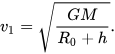

In [ ]:
print(content)

In [ ]:
import google.auth

credentials, project = google.auth.default()
print(credentials.scopes)

None


# Обновелние кода:

## ColabNotebookManager.get_notebooks

In [ ]:
def get_notebooks(self) -> List[Dict[str, Any]]:
    notebooks = []
    if not self.service:
        self.log_handler.log("Сервис не инициализирован, вызовите authenticate()")
        return notebooks

    query = "(mimeType='application/vnd.google.colaboratory' or mimeType='application/x-ipynb+json')"
    page_token = None

    while True:
        try:
            response = self.service.files().list(
                q=query,
                fields="nextPageToken, files(id, name, webViewLink, owners)",
                pageToken=page_token
            ).execute()
        except HttpError as e:
            self.log_handler.log(f"Ошибка запроса к Drive API: {e}")
            break

        files = response.get('files', [])
        for file in files:
            # Ваша текущая фильтрация по имени и владельцу
            if "untitled" in file['name'].lower():
                continue
            owners = file.get('owners', [])
            if not any(owner.get('emailAddress', '') == self.user_email for owner in owners):
                continue

            notebooks.append({
                "id": file['id'],
                "name": file['name'],
                "link": file.get('webViewLink', '')
            })

        page_token = response.get('nextPageToken')
        if not page_token:
            break

    self.log_handler.log(f"Найдено ноутбуков: {len(notebooks)}")
    return notebooks


Функция `get_notebooks` класса `ColabNotebookManager` теперь получает полный список ноутбуков пользователя. Пример: до обновления 32 ноутбука - после обновления 92 ноутбука.

## ColabNotebookManager.get_notebook_content

In [ ]:
    def get_notebook_content(self, notebook_id: str) -> Optional[Dict]:
        """Получение содержимого ноутбука в формате JSON"""
        try:
            self.log_handler.log(f"Загрузка содержимого ноутбука {notebook_id}")

            file_metadata = self.service.files().get(fileId=notebook_id, fields='mimeType').execute()
            mime_type = file_metadata.get('mimeType')

            # Для Google Colab и обычных ipynb файлов — скачиваем через get_media
            if mime_type in ['application/vnd.google.colaboratory', 'application/ipynb+json', 'application/json', 'application/octet-stream']:
                request = self.service.files().get_media(fileId=notebook_id)
                fh = io.BytesIO()
                downloader = MediaIoBaseDownload(fh, request)

                done = False
                while not done:
                    status, done = downloader.next_chunk()

                content = fh.getvalue().decode('utf-8')
                return json.loads(content)

            # Если вдруг файл Google Docs и поддерживает экспорт — экспортируем в json (редкий случай)
            elif mime_type in ['application/vnd.google-apps.document',
                               'application/vnd.google-apps.spreadsheet',
                               'application/vnd.google-apps.presentation']:
                export_mime = 'application/json'  # Или другой подходящий mimeType для экспорта
                content = self.service.files().export(fileId=notebook_id, mimeType=export_mime).execute()
                return json.loads(content.decode('utf-8'))

            else:
                self.log_handler.log(f"Неподдерживаемый mimeType файла {mime_type} для ноутбука {notebook_id}", "WARNING")
                return None

        except HttpError as e:
            if e.resp.status == 403:
                self.log_handler.log(f"Нет доступа к ноутбуку {notebook_id}, пропускаем", "WARNING")
            else:
                self.log_handler.log(f"HTTP ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None
        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None

Функция `get_notebook_content` класса `ColabNotebookManager` теперь корректно получает контент из ноутбука. До этого приходитлось прибегать к методу временной копии.

In [ ]:
import requests
response = requests.get("https://ipinfo.io/json")
print(response.json())

{'ip': '35.232.130.112', 'hostname': '112.130.232.35.bc.googleusercontent.com', 'city': 'Council Bluffs', 'region': 'Iowa', 'country': 'US', 'loc': '41.2619,-95.8608', 'org': 'AS396982 Google LLC', 'postal': '51502', 'timezone': 'America/Chicago', 'readme': 'https://ipinfo.io/missingauth'}


## Обновленная загрузка модели

In [ ]:
# Новые импорты в начале файла
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
import torch
from llama_index.core import VectorStoreIndex, Document, Settings
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
import chromadb

# МОДУЛЬ РАБОТЫ С LLM (полностью переписанный)

class LLMProcessor:
    """Процессор для работы с локальной Llama моделью через HuggingFace"""

    def __init__(self, model_name: str, log_handler: LogHandler):
        self.log_handler = log_handler
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.llm = None
        self.device = "cuda"

        self._load_model()

    def _load_model(self):
        """Загрузка модели и токенизатора"""
        try:
            self.log_handler.log(f"Загрузка модели {self.model_name} на {self.device}")

            # Загрузка токенизатора
            self.tokenizer = AutoTokenizer.from_pretrained(
                self.model_name,
                trust_remote_code=True
            )

            # Добавляем pad_token если его нет
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            # Загрузка модели с оптимизациями для Colab
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float16 if self.device == "cuda" else torch.float32,
                device_map="auto",
                trust_remote_code=True,
                low_cpu_mem_usage=True
            )

            # Создание LlamaIndex LLM
            self.llm = HuggingFaceLLM(
                model=self.model,
                tokenizer=self.tokenizer,
                device_map="auto",
                model_kwargs={
                    "torch_dtype": torch.float16 if self.device == "cuda" else torch.float32,
                    "low_cpu_mem_usage": True
                },
                generate_kwargs={
                    "do_sample": True,
                    "temperature": 0.3,
                    "max_new_tokens": 512,
                    "pad_token_id": self.tokenizer.eos_token_id
                }
            )

            self.log_handler.log("Модель загружена успешно")

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки модели: {str(e)}", "ERROR")
            raise

    def count_tokens(self, text: str) -> int:
        """Подсчет токенов в тексте"""
        if self.tokenizer:
            return len(self.tokenizer.encode(text))
        return 0

    def _generate_response(self, prompt: str) -> str:
        """Генерация ответа от модели"""
        try:
            # Форматирование промпта для Llama
            formatted_prompt = f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n{prompt}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n"

            inputs = self.tokenizer(
                formatted_prompt,
                return_tensors="pt",
                truncation=True,
                max_length=2048
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=512,
                    do_sample=True,
                    temperature=0.3,
                    pad_token_id=self.tokenizer.eos_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )

            # Декодирование только новых токенов
            response = self.tokenizer.decode(
                outputs[0][inputs['input_ids'].shape[1]:],
                skip_special_tokens=True
            )

            return response.strip()

        except Exception as e:
            self.log_handler.log(f"Ошибка генерации ответа: {str(e)}", "ERROR")
            return f"Ошибка генерации: {str(e)}"

    def describe_code_element(self, element: Dict) -> str:
        """Получение описания элемента кода от LLM"""
        try:
            element_type = element.get('type', 'function')
            element_name = element.get('name', 'unknown')
            element_code = element.get('code', '')

            prompt = f"""Проанализируй следующий код {element_type} '{element_name}' и опиши его в формате:

{element_name}
Логическая задача
Краткое описание способа выполнения задачи

Код:
```python
{element_code}

Ответ должен быть структурированным и кратким."""

            response = self._generate_response(prompt)
            self.log_handler.log(f"Получено описание для {element_type} {element_name}")

            return response

        except Exception as e:
            self.log_handler.log(f"Ошибка получения описания от LLM: {str(e)}", "ERROR")
            return f"Ошибка описания {element.get('name', 'unknown')}"

    def describe_class_with_methods(self, class_element: Dict) -> str:
        """Получение описания класса с методами"""
        try:
            class_name = class_element.get('name', 'unknown')
            methods = class_element.get('methods', [])

            # Сначала получаем описания методов
            method_descriptions = []
            for method in methods:
                method_desc = self.describe_code_element(method)
                method_descriptions.append(method_desc)

            # Затем описываем весь класс
            methods_summary = '\n'.join([f"- {method['name']}" for method in methods])

            prompt = f"""Проанализируй класс '{class_name}' с методами и опиши его в формате:

{class_name} Логическая задача Краткое описание способа выполнения задачи

Методы класса: {methods_summary}

Описания методов: {chr(10).join(method_descriptions)}

Дай общее описание класса и его назначения."""

            response = self._generate_response(prompt)
            self.log_handler.log(f"Получено описание для класса {class_name}")

            return response

        except Exception as e:
            self.log_handler.log(f"Ошибка получения описания класса от LLM: {str(e)}", "ERROR")
            return f"Ошибка описания класса {class_element.get('name', 'unknown')}"

    def process_notebook_descriptions(self, notebook_data: Dict) -> str:
        """Обработка всех элементов кода в ноутбуке"""
        try:
            code_elements = notebook_data.get('code_elements', {'functions': [], 'classes': []})
            descriptions = []

            # Обработка функций
            for function in code_elements['functions']:
                desc = self.describe_code_element(function)
                descriptions.append(desc)

            # Обработка классов
            for class_element in code_elements['classes']:
                desc = self.describe_class_with_methods(class_element)
                descriptions.append(desc)

            return '\n\n'.join(descriptions) if descriptions else 'Нет описаний'

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки описаний: {str(e)}", "ERROR")
            return 'Ошибка обработки описаний'

Теперь LLM работает через LlamaIndex. Это упрощает создание инференса а так же позволяет объединить в одном воркфрейме как модель так и базу и проще выполнять RAG поиск

## Обновелние кода векторной базы

In [ ]:
class ChromaManager:
    """Менеджер для работы с векторной базой Chroma через LlamaIndex"""
    def __init__(self, llm_processor: LLMProcessor, log_handler: LogHandler):
        self.log_handler = log_handler
        self.llm_processor = llm_processor

        # Инициализация эмбеддингов
        self.embeddings = HuggingFaceEmbedding(
            model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        )

        # Настройка LlamaIndex
        Settings.llm = llm_processor.llm
        Settings.embed_model = self.embeddings

        self.chroma_client = None
        self.vector_store = None
        self.index = None
        self.query_engine = None

    def create_vectorstore(self, df: pd.DataFrame) -> bool:
        """Создание векторной базы из датафрейма"""
        try:
            self.log_handler.log("Создание векторной базы Chroma через LlamaIndex")

            # Создание Chroma клиента
            self.chroma_client = chromadb.PersistentClient(path="./chroma_db")

            # Получение или создание коллекции
            try:
                collection = self.chroma_client.get_collection("notebooks")
                self.chroma_client.delete_collection("notebooks")
            except:
                pass

            collection = self.chroma_client.create_collection("notebooks")

            # Создание ChromaVectorStore
            self.vector_store = ChromaVectorStore(chroma_collection=collection)

            # Подготовка документов
            documents = []
            for _, row in df.iterrows():
                doc_content = f"""
    Название: {row['название']} Заголовки: {row['заголовки']} Описание: {row['описание']} Итог: {row['итог']} """

                metadata = {
                    'ссылка': row['ссылка'],
                    'библиотеки': row['библиотеки'],
                    'классы и функции': row['классы и функции']
                }

                documents.append(Document(text=doc_content, metadata=metadata))

            # Создание индекса
            self.index = VectorStoreIndex.from_documents(
                documents,
                vector_store=self.vector_store
            )

            # Создание query engine
            self.query_engine = self.index.as_query_engine(
                similarity_top_k=3,
            )

            self.log_handler.log(f"Векторная база создана с {len(documents)} документами")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка создания векторной базы: {str(e)}", "ERROR")
            return False

    def query(self, question: str) -> Tuple[str, int, List[str]]:
        """Запрос к векторной базе"""
        try:
            if not self.query_engine:
                return "Векторная база не создана", 0, []

            self.log_handler.log(f"Обработка запроса: {question}")

            # Подсчет токенов в запросе
            input_tokens = self.llm_processor.count_tokens(question)

            # Выполнение запроса
            response = self.query_engine.query(question)

            # Подсчет токенов в ответе
            output_tokens = self.llm_processor.count_tokens(str(response))
            total_tokens = input_tokens + output_tokens

            # Извлечение ссылок из источников
            links = []
            if hasattr(response, 'source_nodes'):
                for node in response.source_nodes:
                    if hasattr(node, 'metadata') and 'ссылка' in node.metadata:
                        link = node.metadata['ссылка']
                        if link and link not in links:
                            links.append(link)

            self.log_handler.log(f"Запрос обработан. Использовано токенов: {total_tokens}")

            return str(response), total_tokens, links

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", 0, []

    def load_existing_vectorstore(self) -> bool:
        """Загрузка существующей векторной базы"""
        try:
            if not os.path.exists("./chroma_db"):
                return False

            self.chroma_client = chromadb.PersistentClient(path="./chroma_db")
            collection = self.chroma_client.get_collection("notebooks")
            self.vector_store = ChromaVectorStore(chroma_collection=collection)
            self.index = VectorStoreIndex.from_vector_store(self.vector_store)
            self.query_engine = self.index.as_query_engine(
                similarity_top_k=3,
            )

            self.log_handler.log("Существующая векторная база загружена")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки существующей базы: {str(e)}", "WARNING")
            return False

## Обновление кода ассистента

In [ ]:
class NotebookAssistant:
    """Главный класс ассистента обработки ноутбуков"""
    def __init__(self):
        self.log_handler = LogHandler()
        self.colab_manager = ColabNotebookManager(self.log_handler)
        self.notebook_processor = NotebookProcessor(self.log_handler)
        self.llm_processor = None
        self.chroma_manager = None
        self.df = None
        self.model_name = "meta-llama/Llama-3.1-8B"  # По умолчанию

    def set_model(self, model_name: str = None) -> str:
        """Установка и загрузка модели"""
        try:
            if model_name:
                self.model_name = model_name

            self.log_handler.log(f"Инициализация модели {self.model_name}")
            self.llm_processor = LLMProcessor(self.model_name, self.log_handler)
            self.chroma_manager = ChromaManager(self.llm_processor, self.log_handler)

            # Попытка загрузить существующую векторную базу
            self.chroma_manager.load_existing_vectorstore()

            self.log_handler.log("Модель инициализирована успешно")
            return "Модель инициализирована успешно"

        except Exception as e:
            self.log_handler.log(f"Ошибка инициализации модели: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    def get_data(self) -> Tuple[str, str]:
        """Получение и обработка данных из ноутбуков"""
        try:
            if not self.llm_processor:
                return "Сначала инициализируйте модель", self.log_handler.get_logs()

            # Остальной код остается таким же...
            self.log_handler.clear_logs()
            self.log_handler.log("Начало обработки ноутбуков")

            # Аутентификация
            if not self.colab_manager.authenticate():
                return "Ошибка аутентификации", self.log_handler.get_logs()

            # Получение ноутбуков
            notebooks = self.colab_manager.get_notebooks()
            if not notebooks:
                return "Подходящие ноутбуки не найдены", self.log_handler.get_logs()

            # Обработка ноутбуков
            processed_data = []
            for notebook in notebooks:
                self.log_handler.log(f"Загрузка ноутбука: {notebook['name']}")

                notebook_content = self.colab_manager.get_notebook_content(notebook['id'])
                if notebook_content:
                    processed_notebook = self.notebook_processor.process_notebook(
                        notebook_content, notebook
                    )

                    if processed_notebook:
                        # Получение описаний от LLM
                        self.log_handler.log(f"Получение описаний от LLM для: {notebook['name']}")
                        description = self.llm_processor.process_notebook_descriptions(processed_notebook)
                        processed_notebook['описание'] = description

                        # Удаляем временные данные
                        del processed_notebook['code_elements']
                        processed_data.append(processed_notebook)

            # Создание датафрейма
            self.df = pd.DataFrame(processed_data)

            self.log_handler.log(f"Обработка завершена. Создан датафрейм с {len(self.df)} записями")

            return f"Успешно обработано {len(self.df)} ноутбуков", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Критическая ошибка: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    # без изменений
    def download_dataframe(self) -> Tuple[str, Optional[str]]:
        """Скачивание датафрейма"""
        try:
            if self.df is None:
                return "Сначала получите данные", None

            filename = f"notebooks_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            filepath = f"/content/{filename}"
            self.df.to_csv(filepath, index=False, encoding='utf-8')

            self.log_handler.log(f"Датафрейм сохранен: {filename}")
            return f"Файл {filename} готов к скачиванию", filepath

        except Exception as e:
            self.log_handler.log(f"Ошибка скачивания: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", None

    # без изменений
    def load_dataframe(self, file_path: str) -> str:
        """Загрузка датафрейма из файла"""
        try:
            if not file_path:
                return "Файл не выбран"

            self.df = pd.read_csv(file_path, encoding='utf-8')
            self.log_handler.log(f"Датафрейм загружен из {file_path}")
            return f"Датафрейм загружен успешно. Записей: {len(self.df)}"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки датафрейма: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # без изменений
    def save_vectorstore(self) -> str:
        """Сохранение векторной базы"""
        try:
            if not self.chroma_manager or not self.chroma_manager.vectorstore:
                return "Векторная база не создана"

            # Chroma автоматически сохраняется в persist_directory
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            backup_dir = f"/content/chroma_backup_{timestamp}"

            shutil.copytree("./chroma_db", backup_dir)

            self.log_handler.log(f"Векторная база сохранена в {backup_dir}")
            return f"База сохранена в {backup_dir}"

        except Exception as e:
            self.log_handler.log(f"Ошибка сохранения базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # подвязана к локальной модели
    def load_vectorstore(self, backup_dir: str) -> str:
        """Загрузка векторной базы"""
        try:
            if not backup_dir:
                return "Папка не выбрана"

            if not self.chroma_manager:
                return "Сначала инициализируйте модель"

            # Удаляем старую базу если есть
            if os.path.exists("./chroma_db"):
                shutil.rmtree("./chroma_db")

            # Копируем загруженную базу
            shutil.copytree(backup_dir, "./chroma_db")

            # Переинициализируем векторную базу
            success = self.chroma_manager.load_existing_vectorstore()

            if success:
                self.log_handler.log(f"Векторная база загружена из {backup_dir}")
                return "База загружена успешно"
            else:
                return "Ошибка загрузки векторной базы"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # подвязана к локальной модели
    def create_vectorstore(self) -> Tuple[str, str]:
        """Создание векторной базы"""
        try:
            if self.df is None:
                return "Сначала получите данные", self.log_handler.get_logs()

            if not self.chroma_manager:
                return "Модель не инициализирована", self.log_handler.get_logs()

            success = self.chroma_manager.create_vectorstore(self.df)

            if success:
                return "Векторная база создана успешно", self.log_handler.get_logs()
            else:
                return "Ошибка создания векторной базы", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка создания базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    # подвязана к локальной модели
    def query_assistant(self, question: str) -> Tuple[str, str, str]:
        """Запрос к ассистенту через LlamaIndex"""
        try:
            if not self.chroma_manager or not self.chroma_manager.query_engine:
                return "Векторная база не создана", "", self.log_handler.get_logs()

            answer, tokens, links = self.chroma_manager.query(question)

            # Форматирование ответа
            response = f"{answer}\n\n"
            if links:
                response += "Ссылки на ноутбуки:\n"
                for i, link in enumerate(links, 1):
                    response += f"{i}. {link}\n"

            token_info = f"Использовано токенов: {tokens}"

            return response, token_info, self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", "", self.log_handler.get_logs()


## Изменение элементов интерфейса

В функции `create_interface()` в табе "⚙️ Настройка" заменена секция API ключа на:


In [ ]:
model_input = gr.Textbox(
    label="Модель HuggingFace",
    value="meta-llama/Llama-3.1-8B",
    placeholder="meta-llama/Llama-3.1-8B"
)
model_btn = gr.Button("Загрузить модель")
model_output = gr.Textbox(label="Статус", interactive=False)

model_btn.click(
    assistant.set_model,
    inputs=[model_input],
    outputs=[model_output]
)

## Добавлены зависимости

In [ ]:
!pip install llama-index sentence-transformers transformers torch accelerate bitsandbytes

INFO: pip is looking at multiple versions of llama-index-indices-managed-llama-cloud to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of llama-index-readers-llama-parse to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

# Сборка ассистента

In [ ]:
!pip install chromadb llama-index sentence-transformers transformers torch accelerate jedi>=0.16 llama-index-vector-stores-chroma llama-index-embeddings-huggingface llama-index-llms-huggingface huggingface_hub

In [ ]:
!pip install -qU bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import logging
import pandas as pd
import torch
import io
import ast
import gradio as gr
from typing import List, Dict, Any, Optional, Tuple, Generator
from datetime import datetime

# Google Colab
from google.colab import auth, drive
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload

# HuggingFace & Transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

# LlamaIndex
from llama_index.core import VectorStoreIndex, Document, Settings
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.llms import CustomLLM, CompletionResponse

# Chroma
import chromadb

# Pydantic
from pydantic import PrivateAttr

## НАСТРОЙКА ЛОГИРОВАНИЯ

In [ ]:
class LogHandler:
    """Обработчик логов для отображения в интерфейсе"""

    def __init__(self):
        self.logs = []
        self._update_callback = None  # Коллбэк для обновления UI
        self.setup_logging()

    def setup_logging(self):
        """Настройка системы логирования"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[logging.StreamHandler()]
        )
        self.logger = logging.getLogger(__name__)

    def set_update_callback(self, callback):
        """Установка функции обратного вызова для обновления UI"""
        self._update_callback = callback

    def log(self, message: str, level: str = "INFO"):
        """Добавление лога с обновлением UI"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        log_entry = f"[{timestamp}] {level}: {message}"
        self.logs.append(log_entry)

        # Выводим в консоль для отладки
        print(log_entry)

        # Обновляем интерфейс, если коллбэк установлен
        if self._update_callback:
            self._update_callback(self.get_logs())

        if level == "ERROR":
            self.logger.error(message)
        elif level == "WARNING":
            self.logger.warning(message)
        else:
            self.logger.info(message)

    def get_logs(self) -> str:
        """Получение всех логов"""
        return "\n".join(self.logs[-50:])  # Последние 50 записей

    def clear_logs(self):
        """Очистка логов"""
        self.logs.clear()

## МОДУЛЬ РАБОТЫ С GOOGLE COLAB API

In [ ]:
class ColabNotebookManager:
    """Менеджер для работы с ноутбуками Google Colab"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler
        self.service = None
        self.user_email = None

    def authenticate(self) -> bool:
        """Аутентификация в Google API"""
        try:
            self.log_handler.log("Начало аутентификации в Google API")
            auth.authenticate_user()
            self.service = build('drive', 'v3')

            # Получаем email пользователя
            about = self.service.about().get(fields='user').execute()
            self.user_email = about['user']['emailAddress']

            self.log_handler.log(f"Аутентификация успешна. Пользователь: {self.user_email}")
            return True

        except Exception as e:
            self.log_handler.log(f"Ошибка аутентификации: {str(e)}", "ERROR")
            return False

    def get_notebooks(self) -> List[Dict[str, Any]]:
        notebooks = []
        if not self.service:
            self.log_handler.log("Сервис не инициализирован, вызовите authenticate()")
            return notebooks

        query = "(mimeType='application/vnd.google.colaboratory' or mimeType='application/x-ipynb+json')"
        page_token = None

        while True:
            try:
                response = self.service.files().list(
                    q=query,
                    fields="nextPageToken, files(id, name, webViewLink, owners)",
                    pageToken=page_token
                ).execute()
            except HttpError as e:
                self.log_handler.log(f"Ошибка запроса к Drive API: {e}")
                break

            files = response.get('files', [])
            for file in files:
                # Ваша текущая фильтрация по имени и владельцу
                if "untitled" in file['name'].lower():
                    continue
                owners = file.get('owners', [])
                if not any(owner.get('emailAddress', '') == self.user_email for owner in owners):
                    continue

                notebooks.append({
                    "id": file['id'],
                    "name": file['name'],
                    "link": file.get('webViewLink', '')
                })

            page_token = response.get('nextPageToken')
            if not page_token:
                break

        self.log_handler.log(f"Найдено ноутбуков: {len(notebooks)}")
        return notebooks

    def get_notebook_content(self, notebook_id: str) -> Optional[Dict]:
        """Получение содержимого ноутбука в формате JSON"""
        try:
            self.log_handler.log(f"Загрузка содержимого ноутбука {notebook_id}")

            file_metadata = self.service.files().get(fileId=notebook_id, fields='mimeType').execute()
            mime_type = file_metadata.get('mimeType')

            # Для Google Colab и обычных ipynb файлов — скачиваем через get_media
            if mime_type in ['application/vnd.google.colaboratory', 'application/ipynb+json', 'application/json', 'application/octet-stream']:
                request = self.service.files().get_media(fileId=notebook_id)
                fh = io.BytesIO()
                downloader = MediaIoBaseDownload(fh, request)

                done = False
                while not done:
                    status, done = downloader.next_chunk()

                content = fh.getvalue().decode('utf-8')
                return json.loads(content)

            # Если вдруг файл Google Docs и поддерживает экспорт — экспортируем в json (редкий случай)
            elif mime_type in ['application/vnd.google-apps.document',
                               'application/vnd.google-apps.spreadsheet',
                               'application/vnd.google-apps.presentation']:
                export_mime = 'application/json'  # Или другой подходящий mimeType для экспорта
                content = self.service.files().export(fileId=notebook_id, mimeType=export_mime).execute()
                return json.loads(content.decode('utf-8'))

            else:
                self.log_handler.log(f"Неподдерживаемый mimeType файла {mime_type} для ноутбука {notebook_id}", "WARNING")
                return None

        except HttpError as e:
            if e.resp.status == 403:
                self.log_handler.log(f"Нет доступа к ноутбуку {notebook_id}, пропускаем", "WARNING")
            else:
                self.log_handler.log(f"HTTP ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None
        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки ноутбука {notebook_id}: {str(e)}", "ERROR")
            return None


## МОДУЛЬ АНАЛИЗА КОДА

In [ ]:
class CodeAnalyzer:
    """Анализатор кода Python"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler

    def extract_imports(self, code: str) -> List[str]:
        """Извлечение импортов из кода"""
        try:
            tree = ast.parse(code)
            imports = []

            for node in ast.walk(tree):
                if isinstance(node, ast.Import):
                    for alias in node.names:
                        imports.append(alias.name)
                elif isinstance(node, ast.ImportFrom):
                    module = node.module or ''
                    for alias in node.names:
                        imports.append(f"{module}.{alias.name}" if module else alias.name)

            return list(set(imports))

        except SyntaxError:
            return []
        except Exception as e:
            self.log_handler.log(f"Ошибка анализа импортов: {str(e)}", "WARNING")
            return []

    def extract_functions_and_classes(self, code: str) -> Dict[str, List[Dict]]:
        """Извлечение функций и классов из кода"""
        try:
            tree = ast.parse(code)
            functions = []
            classes = []

            # Сначала найдем все классы для проверки вложенности
            class_nodes = [node for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]

            for node in ast.walk(tree):
                if isinstance(node, ast.FunctionDef):
                    # Проверяем, что функция не внутри класса
                    is_inside_class = False
                    for class_node in class_nodes:
                        if node in class_node.body:
                            is_inside_class = True
                            break

                    if not is_inside_class:
                        try:
                            functions.append({
                                'name': node.name,
                                'code': ast.unparse(node) if hasattr(ast, 'unparse') else f"def {node.name}(...): ...",
                                'type': 'function'
                            })
                        except:
                            functions.append({
                                'name': node.name,
                                'code': f"def {node.name}(...): ...",
                                'type': 'function'
                            })

                elif isinstance(node, ast.ClassDef):
                    methods = []
                    for item in node.body:
                        if isinstance(item, ast.FunctionDef):
                            try:
                                methods.append({
                                    'name': item.name,
                                    'code': ast.unparse(item) if hasattr(ast, 'unparse') else f"def {item.name}(...): ...",
                                    'type': 'method'
                                })
                            except:
                                methods.append({
                                    'name': item.name,
                                    'code': f"def {item.name}(...): ...",
                                    'type': 'method'
                                })

                    try:
                        class_code = ast.unparse(node) if hasattr(ast, 'unparse') else f"class {node.name}: ..."
                    except:
                        class_code = f"class {node.name}: ..."

                    classes.append({
                        'name': node.name,
                        'code': class_code,
                        'methods': methods,
                        'type': 'class'
                    })

            return {'functions': functions, 'classes': classes}

        except SyntaxError:
            return {'functions': [], 'classes': []}
        except Exception as e:
            self.log_handler.log(f"Ошибка анализа функций и классов: {str(e)}", "WARNING")
            return {'functions': [], 'classes': []}

## МОДУЛЬ ОБРАБОТКИ НОУТБУКОВ

In [ ]:
class NotebookProcessor:
    """Процессор для анализа ноутбуков"""

    def __init__(self, log_handler: LogHandler):
        self.log_handler = log_handler
        self.code_analyzer = CodeAnalyzer(log_handler)

    def extract_headers(self, cells: List[Dict]) -> List[str]:
        """Извлечение заголовков из ячеек markdown"""
        headers = []

        for cell in cells:
            if cell.get('cell_type') == 'markdown':
                source = ''.join(cell.get('source', []))
                lines = source.split('\n')

                for line in lines:
                    line = line.strip()
                    if line.startswith('#'):
                        # Очистка заголовка от лишних символов
                        header = line.lstrip('#').strip()
                        if header:
                            headers.append(header)

        return headers

    def extract_conclusion(self, cells: List[Dict]) -> str:
        """Извлечение текста после заголовка 'Итог'"""
        conclusion_found = False
        conclusion_text = []

        for cell in cells:
            if cell.get('cell_type') == 'markdown':
                source = ''.join(cell.get('source', []))
                lines = source.split('\n')

                for line in lines:
                    line_clean = line.strip().lower()
                    if line_clean.startswith('#') and 'итог' in line_clean:
                        conclusion_found = True
                        continue

                    if conclusion_found:
                        if line.strip().startswith('#'):
                            # Новый заголовок - прекращаем сбор
                            break
                        conclusion_text.append(line)

        result = '\n'.join(conclusion_text).strip()
        return result if result else "Нет итога"

    def extract_code_elements(self, cells: List[Dict]) -> Tuple[List[str], Dict]:
        """Извлечение импортов, функций и классов из кода"""
        all_imports = []
        all_code_elements = {'functions': [], 'classes': []}

        for cell in cells:
            if cell.get('cell_type') == 'code':
                source = ''.join(cell.get('source', []))

                # Очистка от магических команд
                lines = source.split('\n')
                clean_lines = []
                for line in lines:
                    if not line.strip().startswith(('!', '%', '?')):
                        clean_lines.append(line)

                clean_code = '\n'.join(clean_lines)

                if clean_code.strip():
                    # Извлечение импортов
                    imports = self.code_analyzer.extract_imports(clean_code)
                    all_imports.extend(imports)

                    # Извлечение функций и классов
                    code_elements = self.code_analyzer.extract_functions_and_classes(clean_code)
                    all_code_elements['functions'].extend(code_elements['functions'])
                    all_code_elements['classes'].extend(code_elements['classes'])

        return list(set(all_imports)), all_code_elements

    def process_notebook(self, notebook_data: Dict, notebook_info: Dict) -> Dict:
        """Обработка одного ноутбука"""
        try:
            self.log_handler.log(f"Обработка ноутбука: {notebook_info['name']}")

            cells = notebook_data.get('cells', [])

            # Извлечение данных
            headers = self.extract_headers(cells)
            conclusion = self.extract_conclusion(cells)
            imports, code_elements = self.extract_code_elements(cells)

            # Формирование списка функций и классов
            functions_and_classes = []
            for func in code_elements['functions']:
                functions_and_classes.append(f"Функция: {func['name']}")
            for cls in code_elements['classes']:
                functions_and_classes.append(f"Класс: {cls['name']}")

            result = {
                'ссылка': notebook_info['link'],
                'название': notebook_info['name'],
                'заголовки': '; '.join(headers) if headers else 'нет заголовков',
                'библиотеки': ', '.join(imports) if imports else 'нет импортов',
                'классы и функции': '; '.join(functions_and_classes) if functions_and_classes else 'нет функций',
                'описание': '',  # Будет заполнено LLM
                'итог': conclusion,
                'code_elements': code_elements  # Для передачи в LLM
            }

            self.log_handler.log(f"Ноутбук {notebook_info['name']} обработан успешно")
            return result

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки ноутбука {notebook_info['name']}: {str(e)}", "ERROR")
            return None

In [ ]:
from llama_index.core.llms import LLMMetadata
from pydantic import Field

class LLMWrapper(CustomLLM):
    # Явно объявляем поле processor через PrivateAttr
    _processor: Any = PrivateAttr()

    # Обязательные поля для CustomLLM
    context_window: int = Field(
        default=16384,
        description="Размер контекстного окна модели"
    )
    model_name: str = Field(
        default="deepseek-coder",
        description="Название модели"
    )

    def __init__(self, processor: Any, **data: Any):
        super().__init__(**data)
        self._processor = processor
        self.model_name = processor._model_id

    @property
    def metadata(self) -> LLMMetadata:
        return LLMMetadata(
            context_window=self.context_window,
            num_output=512,
            model_name=self.model_name,
            is_chat_model=True,
        )

    @property
    def llm_metadata(self) -> LLMMetadata:
        """Для совместимости со старыми версиями"""
        return self.metadata

    def complete(self, prompt: str, **kwargs) -> CompletionResponse:
        return self._processor.complete(prompt, **kwargs)

    def stream_complete(self, prompt: str, **kwargs) -> Generator[CompletionResponse, None, None]:
        response = self.complete(prompt, **kwargs)
        yield response

## Класс загрузки модели

In [ ]:
class LLMProcessor(CustomLLM):
    _tokenizer: Any = PrivateAttr()
    _model: Any = PrivateAttr()
    _model_id: str = PrivateAttr()
    _log_handler: Any = PrivateAttr()
    _system_prompt: str = PrivateAttr()

    def __init__(self, model_id: str, log_handler: Any, hf_token: str = None):
        super().__init__()
        self._model_id = model_id
        self._log_handler = log_handler
        self._system_prompt = "Ты эксперт по Python-коду. Отвечай на русском языке."
        self._description_cache = {}  # Кэш для хранения описаний

        try:
            self._log_handler.log(f"Загрузка модели {model_id}")

            # Загрузка через transformers
            self._tokenizer = AutoTokenizer.from_pretrained(
                model_id,
                token=hf_token,
                trust_remote_code=True
            )
            self._model = AutoModelForCausalLM.from_pretrained(
                model_id,
                token=hf_token,
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True
            )

            self._log_handler.log("Модель успешно загружена")

        except Exception as e:
            error_msg = f"Ошибка загрузки модели: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            raise RuntimeError(error_msg)

    @property
    def context_window(self) -> int:
        return 16384

    @property
    def model_name(self) -> str:
        return self._model_id

    @property
    def metadata(self) -> Dict[str, Any]:
        return {
            "model_name": self.model_name,  # Используем property
            "context_window": self.context_window,  # Используем property
        }

    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        """Основной метод генерации ответа"""
        try:
            # Формируем сообщения в формате чата
            messages = [
                {"role": "system", "content": self._system_prompt},
                {"role": "user", "content": prompt}
            ]

            # Применяем шаблон чата
            inputs = self._tokenizer.apply_chat_template(
                messages,
                return_tensors="pt",
                add_generation_prompt=True
            ).to(self._model.device)

            # Генерация ответа
            outputs = self._model.generate(
                inputs,
                max_new_tokens=512,
                pad_token_id=self._tokenizer.eos_token_id,
                eos_token_id=self._tokenizer.eos_token_id,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                repetition_penalty=1.1
            )

            # Извлекаем только ответ модели
            response_tokens = outputs[0][inputs.shape[1]:]
            response_text = self._tokenizer.decode(
                response_tokens,
                skip_special_tokens=True
            ).strip()

            return CompletionResponse(text=response_text)

        except Exception as e:
            error_msg = f"Ошибка генерации: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            return CompletionResponse(text=error_msg)

    def _generate_response(self, prompt: str) -> str:
        """Обертка для совместимости со старым кодом"""
        return self.complete(prompt).text

    def describe_code_element(self, element: Dict) -> str:
        """Генерация или получение описания из кэша"""
        # Формируем уникальный ключ кэша
        cache_key = self._get_cache_key(element)

        # Возвращаем описание из кэша, если есть
        if cache_key in self._description_cache:
            self._log_handler.log(f"Используем кэшированное описание для {cache_key}")
            return self._description_cache[cache_key]

        try:
            element_type = element.get('type', 'function')
            element_name = element.get('name', 'unknown')
            element_code = element.get('code', '')

            prompt = (
                f"Опиши одним предложением назначение {element_type} {element_name}:\n"
                f"```python\n{element_code}\n```"
            )

            self._log_handler.log(f"Генерация описания для {cache_key}")
            description = self._generate_response(prompt)

            # Сохраняем в кэш перед возвратом
            self._description_cache[cache_key] = description
            return description

        except Exception as e:
            error_msg = f"Ошибка описания элемента {element_name}: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            # Сохраняем ошибку в кэш, чтобы не повторять запрос
            self._description_cache[cache_key] = error_msg
            return error_msg

    def _get_cache_key(self, element: Dict) -> str:
        """Генерация уникального ключа кэша для элемента"""
        element_type = element.get('type', 'function')
        element_name = element.get('name', 'unknown')

        # Для методов добавляем имя класса в ключ
        if element_type == 'method' and 'class_name' in element:
            return f"method_{element['class_name']}_{element_name}"

        return f"{element_type}_{element_name}"

    def describe_class_with_methods(self, class_element: Dict) -> str:
        """Генерация описания класса с использованием кэшированных описаний методов"""
        class_name = class_element.get('name', 'unknown')
        class_cache_key = f"class_{class_name}"

        # Проверяем кэш для класса
        if class_cache_key in self._description_cache:
            self._log_handler.log(f"Используем кэшированное описание класса {class_name}")
            return self._description_cache[class_cache_key]

        try:
            methods = class_element.get('methods', [])
            class_code = class_element.get('code', '')

            # Собираем кэшированные описания методов
            method_descriptions = []
            for method in methods:
                # Генерируем и кэшируем описание с указанием класса
                method_desc = self.describe_code_element({
                    'type': 'method',
                    'name': method['name'],
                    'code': method['code'],
                    'class_name': class_name  # Добавляем для уникальности ключа
                })
                method_descriptions.append(f"- {method['name']}: {method_desc}")

            # Формируем промпт
            if method_descriptions:
                methods_text = "\n".join(method_descriptions)
                prompt = (
                    f"Опиши назначение класса '{class_name}' на основе его методов:\n"
                    f"{methods_text}\n\n"
                    f"Кратко сформулируй общую цель класса."
                )
            else:
                prompt = (
                    f"Опиши назначение класса '{class_name}' на основе его кода:\n"
                    f"```python\n{class_code}\n```"
                )

            description = self._generate_response(prompt)

            # Сохраняем описание класса в кэш
            self._description_cache[class_cache_key] = description
            return description

        except Exception as e:
            error_msg = f"Ошибка описания класса {class_name}: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            # Сохраняем ошибку в кэш
            self._description_cache[class_cache_key] = error_msg
            return error_msg

    def process_notebook_descriptions(self, notebook_data: Dict) -> str:
        """Обработка всех элементов кода в ноутбуке"""
        try:
            code_elements = notebook_data.get('code_elements', {'functions': [], 'classes': []})
            descriptions = []

            # Обработка функций
            for function in code_elements['functions']:
                descriptions.append(self.describe_code_element(function))

            # Обработка классов
            for class_element in code_elements['classes']:
                descriptions.append(self.describe_class_with_methods(class_element))

            return '\n\n'.join(descriptions) if descriptions else 'Нет описаний'

        except Exception as e:
            error_msg = f"Ошибка обработки описаний: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            return error_msg

    def stream_complete(self, prompt: str, **kwargs: Any) -> Generator[CompletionResponse, None, None]:
        """Упрощенная потоковая реализация"""
        response = self.complete(prompt)
        yield response

## МОДУЛЬ РАБОТЫ С ВЕКТОРНОЙ БАЗОЙ

In [ ]:
class ChromaManager:
    """Менеджер для работы с векторной базой Chroma через LlamaIndex"""
    def __init__(self, llm_processor: LLMWrapper, log_handler: LogHandler):
        self.log_handler = log_handler
        self.llm_processor = llm_processor

        # Инициализация эмбеддингов
        self.embeddings = HuggingFaceEmbedding(
            model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
        )

        # Сброс глобальных настроек
        from llama_index.core import Settings
        Settings.llm = llm_processor
        Settings.embed_model = self.embeddings

        self.chroma_client = None
        self.vector_store = None
        self.index = None
        self.query_engine = None

    def create_vectorstore(self, df: pd.DataFrame) -> bool:
        """Создание векторной базы из датафрейма"""
        try:
            self.log_handler.log("Создание векторной базы Chroma через LlamaIndex")
            from llama_index.core import Settings
            self.log_handler.log(f"Текущие настройки LlamaIndex:")
            self.log_handler.log(f"LLM: {type(Settings.llm).__name__}")
            self.log_handler.log(f"Embeddings: {type(Settings.embed_model).__name__}")
            self.log_handler.log(f"Тип llm_processor: {type(self.llm_processor)}")
            self.log_handler.log(f"context_window: {self.llm_processor.context_window}")
            self.log_handler.log(f"model_name: {self.llm_processor.model_name}")
            self.log_handler.log(f"Атрибуты llm: {dir(Settings.llm)}")

            # Создание Chroma клиента
            self.chroma_client = chromadb.PersistentClient(path="./chroma_db")

            # Получение или создание коллекции
            try:
                collection = self.chroma_client.get_collection("notebooks")
                self.chroma_client.delete_collection("notebooks")
            except:
                pass

            collection = self.chroma_client.create_collection("notebooks")

            # Создание ChromaVectorStore
            self.vector_store = ChromaVectorStore(chroma_collection=collection)

            # Подготовка документов
            documents = []
            for _, row in df.iterrows():
                doc_content = f"""
                Название: {row['название']}
                Заголовки: {row['заголовки']}
                Описание: {row['описание']}
                Итог: {row['итог']} """

                metadata = {
                    'ссылка': row['ссылка'],
                    'библиотеки': row['библиотеки'],
                    'классы и функции': row['классы и функции']
                }

                documents.append(Document(page_content=doc_content, metadata=metadata))

            # Проверка типа llm_processor перед использованием
            if not isinstance(self.llm_processor, CustomLLM):
                self.log_handler.log(f"Ошибка: llm_processor имеет неверный тип {type(self.llm_processor)}", "ERROR")
                return False

            # Проверка наличия необходимых атрибутов
            required_attrs = ['context_window', 'model_name']
            for attr in required_attrs:
                if not hasattr(self.llm_processor, attr):
                    self.log_handler.log(f"Ошибка: llm_processor не имеет атрибута {attr}", "ERROR")
                    return False

            # Проверка типа метаданных
            self.log_handler.log(f"Тип метаданных: {type(self.llm_processor.metadata)}")
            self.log_handler.log(f"Context_window: {self.llm_processor.metadata.context_window}")

            self.index = VectorStoreIndex.from_documents(
                documents,
                vector_store=self.vector_store,
                embed_model=self.embeddings,
                llm=self.llm_processor  # Используем обернутую LLM
            )

            # Создание query engine
            self.query_engine = self.index.as_query_engine(
                similarity_top_k=5,
                )

            self.log_handler.log(f"Векторная база создана с {len(documents)} документами")
            return True

        except Exception as e:
            import traceback
            tb = traceback.format_exc()
            self.log_handler.log(f"Полный стек ошибки:\n{tb}", "ERROR")
            return False
            self.log_handler.log(f"Ошибка создания векторной базы: {str(e)}", "ERROR")
            return False

    def query(self, question: str) -> Tuple[str, List[str]]:
        """Запрос к векторной базе"""
        try:
            if not self.query_engine:
                return "Векторная база не создана", []

            self.log_handler.log(f"Обработка запроса: {question}")

            # Выполнение запроса
            response = self.query_engine.query(question)

            # Извлечение ссылок из источников
            links = []
            if hasattr(response, 'source_nodes'):
                for node in response.source_nodes:
                    if hasattr(node, 'metadata') and 'ссылка' in node.metadata:
                        link = node.metadata['ссылка']
                        if link and link not in links:
                            links.append(link)

            self.log_handler.log(f"Запрос обработан.")

            return str(response), links

        except Exception as e:
            self.log_handler.log(f"Ошибка обработки запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", []

    def load_existing_vectorstore(self) -> bool:
            """Загрузка существующей векторной базы"""
            try:
                if not os.path.exists("./chroma_db"):
                    return False

                self.chroma_client = chromadb.PersistentClient(path="./chroma_db")
                collection = self.chroma_client.get_collection("notebooks")
                self.vector_store = ChromaVectorStore(chroma_collection=collection)


                self.index = VectorStoreIndex.from_vector_store(
                    self.vector_store,
                )

                self.query_engine = self.index.as_query_engine(
                    similarity_top_k=5,
                )

                self.log_handler.log("Существующая векторная база загружена")
                return True

            except Exception as e:
                self.log_handler.log(f"Ошибка загрузки существующей базы: {str(e)}", "WARNING")
                return False

## ГЛАВНЫЙ КЛАСС ПРИЛОЖЕНИЯ

In [ ]:
class NotebookAssistant:
    """Главный класс ассистента обработки ноутбуков"""
    def __init__(self):
        self.log_handler = LogHandler()
        self.colab_manager = ColabNotebookManager(self.log_handler)
        self.notebook_processor = NotebookProcessor(self.log_handler)
        self.llm_processor = None
        self.chroma_manager = None
        self.df = None
        self.model_name = "deepseek-ai/deepseek-coder-6.7b-instruct"  # По умолчанию

    def set_model(self, model_name: str = None, hf_token: str = None) -> str:
        """Установка и загрузки модели"""
        try:
            if model_name:
                self.model_name = model_name

            if hf_token:
                from huggingface_hub import login
                login(token=hf_token)

            self.log_handler.log(f"Инициализация модели {self.model_name}")

            # Создаем основной процессор
            raw_processor = LLMProcessor(self.model_name, self.log_handler, hf_token=hf_token)

            # Оборачиваем процессор в LLMWrapper
            self.llm_processor = LLMWrapper(processor=raw_processor)

            # Инициализируем ChromaManager
            self.chroma_manager = ChromaManager(self.llm_processor, self.log_handler)

            # Настройка глобальных параметров
            from llama_index.core import Settings
            Settings.llm = self.llm_processor
            Settings.embed_model = self.chroma_manager.embeddings
            self.log_handler.log("Глобальные настройки установлены")

            # Попытка загрузки векторной базы
            self.chroma_manager.load_existing_vectorstore()

            self.log_handler.log("Модель инициализирована успешно")
            return "✅ Модель загружена успешно"

        except Exception as e:
            self.log_handler.log(f"Ошибка инициализации модели: {str(e)}", "ERROR")
            return f"❌ Ошибка: {str(e)}"

    def get_model_status(self) -> str:
        """Получение статуса модели"""
        if self.llm_processor is None:
            return "❌ Модель не загружена"
        else:
            return f"✅ Модель загружена: {self.model_name}"

    def get_data(self) -> Tuple[str, str]:
        """Получение и обработка данных из ноутбуков"""
        try:
            if not self.llm_processor:
                return "Сначала инициализируйте модель", self.log_handler.get_logs()


            self.log_handler.clear_logs()
            self.log_handler.log("Начало обработки ноутбуков")

            # Аутентификация
            if not self.colab_manager.authenticate():
                return "Ошибка аутентификации", self.log_handler.get_logs()

            # Получение ноутбуков
            notebooks = self.colab_manager.get_notebooks()
            if not notebooks:
                return "Подходящие ноутбуки не найдены", self.log_handler.get_logs()

            # Обработка ноутбуков
            processed_data = []
            for notebook in notebooks:
                self.log_handler.log(f"Загрузка ноутбука: {notebook['name']}")

                notebook_content = self.colab_manager.get_notebook_content(notebook['id'])
                if notebook_content:
                    processed_notebook = self.notebook_processor.process_notebook(
                        notebook_content, notebook
                    )

                    if processed_notebook:
                        # Получение описаний от LLM
                        self.log_handler.log(f"Получение описаний от LLM для: {notebook['name']}")
                        description = self.llm_processor.process_notebook_descriptions(processed_notebook)
                        processed_notebook['описание'] = description

                        # Удаляем временные данные
                        del processed_notebook['code_elements']
                        processed_data.append(processed_notebook)

            # Создание датафрейма
            self.df = pd.DataFrame(processed_data)

            self.log_handler.log(f"Обработка завершена. Создан датафрейм с {len(self.df)} записями")

            return f"Успешно обработано {len(self.df)} ноутбуков", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Критическая ошибка: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    # без изменений
    def download_dataframe(self) -> Tuple[str, Optional[str]]:
        """Скачивание датафрейма"""
        try:
            if self.df is None:
                return "Сначала получите данные", None

            filename = f"notebooks_data_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            filepath = f"/content/{filename}"
            self.df.to_csv(filepath, index=False, encoding='utf-8')

            self.log_handler.log(f"Датафрейм сохранен: {filename}")
            return f"Файл {filename} готов к скачиванию", filepath

        except Exception as e:
            self.log_handler.log(f"Ошибка скачивания: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", None

    # без изменений
    def load_dataframe(self, file_path: str) -> str:
        """Загрузка датафрейма из файла"""
        try:
            if not file_path:
                return "Файл не выбран"

            self.df = pd.read_csv(file_path, encoding='utf-8')
            self.log_handler.log(f"Датафрейм загружен из {file_path}")
            return f"Датафрейм загружен успешно. Записей: {len(self.df)}"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки датафрейма: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # без изменений
    def save_vectorstore(self) -> str:
        """Сохранение векторной базы"""
        try:
            if not self.chroma_manager or not self.chroma_manager.vector_store:
                return "Векторная база не создана"

            # Chroma автоматически сохраняется в persist_directory
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            backup_dir = f"/content/chroma_backup_{timestamp}"

            shutil.copytree("./chroma_db", backup_dir)

            self.log_handler.log(f"Векторная база сохранена в {backup_dir}")
            return f"База сохранена в {backup_dir}"

        except Exception as e:
            self.log_handler.log(f"Ошибка сохранения базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # подвязана к локальной модели
    def load_vectorstore(self, backup_dir: str) -> str:
        """Загрузка векторной базы"""
        try:
            if not backup_dir:
                return "Папка не выбрана"

            if not self.chroma_manager:
                return "Сначала инициализируйте модель"

            # Удаляем старую базу если есть
            if os.path.exists("./chroma_db"):
                shutil.rmtree("./chroma_db")

            # Копируем загруженную базу
            shutil.copytree(backup_dir, "./chroma_db")

            # Переинициализируем векторную базу
            success = self.chroma_manager.load_existing_vectorstore()

            if success:
                self.log_handler.log(f"Векторная база загружена из {backup_dir}")
                return "База загружена успешно"
            else:
                return "Ошибка загрузки векторной базы"

        except Exception as e:
            self.log_handler.log(f"Ошибка загрузки базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}"

    # подвязана к локальной модели
    def create_vectorstore(self) -> Tuple[str, str]:
        """Создание векторной базы"""
        try:
            if self.df is None:
                return "Сначала получите данные", self.log_handler.get_logs()

            if not self.chroma_manager:
                return "Модель не инициализирована", self.log_handler.get_logs()

            success = self.chroma_manager.create_vectorstore(self.df)

            if success:
                return "Векторная база создана успешно", self.log_handler.get_logs()
            else:
                return "Ошибка создания векторной базы", self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка создания базы: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()

    # подвязана к локальной модели
    def query_assistant(self, question: str) -> Tuple[str, str]:
        """Запрос к ассистенту через LlamaIndex"""
        try:
            if not self.chroma_manager or not self.chroma_manager.query_engine:
                return "Векторная база не создана", self.log_handler.get_logs()

            answer, links = self.chroma_manager.query(question)

            # Форматирование ответа
            response = f"{answer}\n\n"
            if links:
                response += "Ссылки на ноутбуки:\n"
                for i, link in enumerate(links, 1):
                    response += f"{i}. {link}\n"

            return response, self.log_handler.get_logs()

        except Exception as e:
            self.log_handler.log(f"Ошибка запроса: {str(e)}", "ERROR")
            return f"Ошибка: {str(e)}", self.log_handler.get_logs()


# Проверка без интерфейса

In [ ]:
from pprint import pprint

def list_notebooks(hf_token: str):
    assistant = NotebookAssistant()

    # Инициализация (без загрузки модели)
    assistant.colab_manager = ColabNotebookManager(assistant.log_handler)

    # Аутентификация
    if not assistant.colab_manager.authenticate():
        print("Ошибка аутентификации")
        return

    # Получение списка
    notebooks = assistant.colab_manager.get_notebooks()

    # Вывод информации
    print(f"\nНайдено ноутбуков: {len(notebooks)}\n")
    for i, nb in enumerate(notebooks, 1):
        print(f"{i}. {nb['name']} (ID: {nb['id']})")
        print(f"   Ссылка: {nb.get('link', 'нет')}")
        print(f"   Владельцы: {[o['emailAddress'] for o in nb.get('owners', [])]}")
        print("-" * 50)

if __name__ == "__main__":
    list_notebooks(hf_token="your_hf_token")


Найдено ноутбуков: 95

1. Копия блокнота "31 Практическая работа "colab assistant upgrade"" (ID: 18deChoX-pOyKkCsRk4qagaFcOVpO42DM)
   Ссылка: https://colab.research.google.com/drive/18deChoX-pOyKkCsRk4qagaFcOVpO42DM
   Владельцы: []
--------------------------------------------------
2. Копия блокнота "проверка модели llama-3.1-8b-instruct" (ID: 1TrAICJOG6FN1YiCuLyadnQsqkWugayDZ)
   Ссылка: https://colab.research.google.com/drive/1TrAICJOG6FN1YiCuLyadnQsqkWugayDZ
   Владельцы: []
--------------------------------------------------
3. 31 Практическая работа "colab assistant upgrade" (ID: 1As00nVn-DyBNj3SCKuGMOuXfxjKePESG)
   Ссылка: https://colab.research.google.com/drive/1As00nVn-DyBNj3SCKuGMOuXfxjKePESG
   Владельцы: []
--------------------------------------------------
4. проверка модели llama-3.1-8b-instruct (ID: 1q1UoCYZ--hp4zAdp9RSWn7SAcg-HViQY)
   Ссылка: https://colab.research.google.com/drive/1q1UoCYZ--hp4zAdp9RSWn7SAcg-HViQY
   Владельцы: []
-----------------------------------

In [ ]:
import logging
from pprint import pprint
import time

# Глобальная переменная для тестирования
global_assistant = None

def setup_logging():
    """Настройка подробного логирования в консоль"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.StreamHandler()]
    )

def process_single_notebook(notebook_id: str, hf_token: str):
    """Обработка одного конкретного ноутбука"""
    global global_assistant

    # Инициализируем только если переменная не существует
    if global_assistant is None:
        print("🆕 Создаем нового ассистента")
        global_assistant = NotebookAssistant()
    else:
        print("♻️ Используем существующего ассистента")

    print(f"\n=== Начинаем обработку ноутбука {notebook_id} ===\n")

    # 1. Инициализация модели
    print("1. Инициализация модели...")
    load_result = global_assistant.set_model(hf_token=hf_token)
    if "успешно" not in load_result.lower():
        print(f"❌ Ошибка загрузки модели: {load_result}")
        return

    # Проверка модели
    print("\nПроверка статуса модели:")
    print(f"Модель загружена: {global_assistant.llm_processor is not None}")

    # Проверка типа и функционала модели
    if global_assistant.llm_processor:

        # Проверка генерации ответа
        test_response = global_assistant.llm_processor._generate_response("Что такое Python?")
        print(f"Тестовый ответ модели:\n{test_response[:100]}...")

    # 2. Аутентификация в Google Drive
    print("\n2. Аутентификация в Google Drive...")
    if not global_assistant.colab_manager.authenticate():
        print("❌ Ошибка аутентификации в Google Drive")
        return

    # 3. Загрузка ноутбука
    print("\n3. Загрузка ноутбука из Colab...")
    notebook_content = global_assistant.colab_manager.get_notebook_content(notebook_id)
    if not notebook_content:
        print("❌ Не удалось загрузить ноутбук")
        return

    # 4. Обработка ноутбука
    print("\n4. Обработка ноутбука...")
    notebook_info = {"id": notebook_id, "name": f"Тестовый ноутбук {notebook_id}", "link": ""}
    result = global_assistant.notebook_processor.process_notebook(notebook_content, notebook_info)

    if not result:
        print("❌ Не удалось обработать ноутбук")
        return

    # 5. Вывод результатов
    print("\n=== Результаты обработки ===")
    pprint(result)

    # 6. Генерация описаний LLM
    if result and 'code_elements' in result:
        print("\n6. Генерация описаний элементов кода:")

        # Для функций
        if result['code_elements']['functions']:
            print("\n=== Описания функций ===")
            for func in result['code_elements']['functions']:
                start_time = time.time()
                description = global_assistant.llm_processor.describe_code_element(func)
                print(f"Время генерации: {time.time() - start_time:.2f} сек")
                print(f"\nФункция: {func['name']}")
                print(f"Описание:\n{description}")
                print("-" * 50)

        # Для классов
        if result['code_elements']['classes']:
            print("\n=== Описания классов ===")
            for cls in result['code_elements']['classes']:
                start_time = time.time()
                description = global_assistant.llm_processor.describe_class_with_methods(cls)
                print(f"Время генерации: {time.time() - start_time:.2f} сек")
                print(f"\nКласс: {cls['name']}")
                print(f"Описание:\n{description}")
                print("-" * 50)

        # Тест простого запроса к модели
        print("\n7. Тест простого запроса к модели:")
        test_prompt = "Назови столицу России"
        start_time = time.time()
        response = global_assistant.llm_processor._generate_response(test_prompt)
        print(f"Время генерации: {time.time() - start_time:.2f} сек")
        print(f"Запрос: {test_prompt}")
        print(f"Ответ: {response}")

if __name__ == "__main__":
    setup_logging()

    # Конфигурация
    NOTEBOOK_ID = "1g4w_K0G66PWvJAY8TUnEb2lCChRrSojP"  # Ваш реальный ID
    HF_TOKEN_RESERVE = "your_hf_token"  # Ваш токен

    # Запуск обработки
    process_single_notebook(NOTEBOOK_ID, HF_TOKEN_RESERVE)

🆕 Создаем нового ассистента

=== Начинаем обработку ноутбука 1g4w_K0G66PWvJAY8TUnEb2lCChRrSojP ===

1. Инициализация модели...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Проверка статуса модели:
Модель загружена: True
Тестовый ответ модели:
Python - это высокоуровневый, interpreted, interactive и объектно-ориентированный скриптовый язык пр...

2. Аутентификация в Google Drive...

3. Загрузка ноутбука из Colab...

4. Обработка ноутбука...

=== Результаты обработки ===
{'code_elements': {'classes': [{'code': 'class GuardedQueryEngine:\n'
                                        '\n'
                                        '    def __init__(self, query_engine, '
                                        'rails):\n'
                                        '        self.query_engine = '
                                        'query_engine\n'
                                        '        self.rails = rails\n'
                                        '        self.jailbreak_patterns = '
                                        "['ignore.*previous.*instruction', "
                                        "'act as.*if.*you.*are', "
                              

# Отдельная загрузка модели и тесты

Далее следуют способы загрузки моделей, варианты промптов и результаты обработки. Самой эффективной моделью оказалась DeepseekCode-7b-instruct. Так же проверял модель Llama-3.1-7b-instruct, но она по своим внутренним причинам игнорировала большую часть инструкций, даже кога выдавала адекватные описания. Так же плюсом ДипсикКод является подтвержденная генерация на русском языке и способность работы с кодом одинаково качественно, когда Llama присбособлена больше для натурального языка, и то в меньшей степени для русского.

In [ ]:
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-hot_1dbu/unsloth_3605d7e029784e5f8f707d6a1296951c
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-hot_1dbu/unsloth_3605d7e029784e5f8f707d6a1296951c
  Resolved https://github.com/unslothai/unsloth.git to commit 5266ead104938c4908c7f2d2a60526555faf7e85
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.3 MB/s eta 0:00:

In [ ]:
import torch
from unsloth import FastLanguageModel

# Конфигурация
MODEL_NAME = "deepseek-ai/deepseek-coder-6.7b-instruct"
HF_TOKEN = "your_hf_token"  # Замените на ваш токен

# Шаг 1: Загрузка модели (выполняется один раз)
def load_model():
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        token=HF_TOKEN,
        max_seq_length=16384,
        dtype=torch.bfloat16,
        load_in_4bit=True,
        attn_implementation="flash_attention_2",
    )
    return model, tokenizer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Шаг 2: Генерация ответа
def generate_response(model, tokenizer, prompt):
    # Форматирование промпта
    formatted_prompt = (
        "Ты эксперт по Python-коду. Отвечай на русском языке.\n\n"
        f"### Запрос:\n{prompt}\n\n"
        f"### Ответ:\n"
    )

    # Токенизация
    inputs = tokenizer(
        formatted_prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=16384,
    ).to("cuda")

    # Генерация
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.1
    )

    # Декодирование ответа (пропускаем промпт)
    response = tokenizer.decode(
        outputs[0][inputs.input_ids.shape[1]:],
        skip_special_tokens=True
    ).strip()

    return response

In [ ]:
    # Загрузка модели (выполнить один раз)
    print("Загрузка модели...")
    model, tokenizer = load_model()
    print("Модель загружена")



Загрузка модели...
==((====))==  Unsloth 2025.7.11: Fast Llama patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Device does not support bfloat16. Will change to float16.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Модель загружена


In [ ]:
    # Тестовые промпты
    test_prompts = [
        "Напиши 'Hello World' на Python",
        "Опиши назначение функции: def filtered_tokens(text):\n    return [token.text for token in tokenize(text)]",
        "Опиши назначение функции: def seq_split(sequence, win_size, step):\n    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]"
    ]

    for i, prompt in enumerate(test_prompts):
        print(f"\n=== Тест {i+1} ===")
        print(f"Промпт: {prompt}")
        response = generate_response(model, tokenizer, prompt)
        print(f"Ответ: {response}\n")


=== Тест 1 ===
Промпт: Напиши 'Hello World' на Python
Ответ: 


=== Тест 2 ===
Промпт: Опиши назначение функции: def filtered_tokens(text):
    return [token.text for token in tokenize(text)]
Ответ: 


=== Тест 3 ===
Промпт: Опиши назначение функции: def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]
Ответ: 



In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Конфигурация
MODEL_NAME = "deepseek-ai/deepseek-coder-6.7b-instruct"
HF_TOKEN = "your_hf_token"  # Замените на ваш токен

# Шаг 1: Загрузка модели
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        trust_remote_code=True
    )
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        token=HF_TOKEN,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True
    )
    return model, tokenizer

# Шаг 2: Генерация ответа с правильным форматированием
def generate_response(model, tokenizer, user_prompt):
    messages = [
        {"role": "system", "content": "Ты эксперт по Python-коду. Отвечай на русском языке."},
        {"role": "user", "content": user_prompt}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        return_tensors="pt",
        add_generation_prompt=True
    ).to(model.device)

    outputs = model.generate(
        inputs,
        max_new_tokens=512,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.1
    )

    # Декодируем только ответ ассистента (пропускаем промпт)
    response = tokenizer.decode(
        outputs[0][inputs.shape[1]:],
        skip_special_tokens=True
    ).strip()

    return response

In [ ]:
    # Загрузка модели
    print("Загрузка модели...")
    model, tokenizer = load_model()
    print("Модель загружена")



Загрузка модели...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Модель загружена


In [ ]:
    # Тестовые промпты
    test_prompts = [
        "Напиши 'Hello World' на Python",
        "Опиши одним предложением не более 25 слов назначение функции: def filtered_tokens(text):\n    return [token.text for token in tokenize(text)]",
        "Опиши одним предложением не более 25 слов назначение функции: def seq_split(sequence, win_size, step):\n    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]"
    ]

    for i, prompt in enumerate(test_prompts):
        print(f"\n=== Тест {i+1} ===")
        print(f"Промпт: {prompt}")
        response = generate_response(model, tokenizer, prompt)
        print(f"Ответ: {response}\n")


=== Тест 1 ===
Промпт: Напиши 'Hello World' на Python
Ответ: ```python
print('Hello, World!')
```


=== Тест 2 ===
Промпт: Опиши одним предложением не более 25 слов назначение функции: def filtered_tokens(text):
    return [token.text for token in tokenize(text)]
Ответ: Функция фильтрует токены текста и возвращает список токенов.


=== Тест 3 ===
Промпт: Опиши одним предложением не более 25 слов назначение функции: def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]
Ответ: Функция разделяет последовательность на непересекающиеся и шаг между ними подпоследовательности заданного размера.



In [ ]:
!pip install llama_index jedi>=0.16

In [ ]:
from llama_index.core.llms import CustomLLM, CompletionResponse
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from typing import Any, List, Optional, Dict, Generator

In [ ]:
class DeepSeekCoderLLM(CustomLLM):
    model_name: str = "deepseek-ai/deepseek-coder-6.7b-instruct"
    tokenizer: Any = None
    model: Any = None
    system_prompt: str = "Ты эксперт по Python-коду. Отвечай на русском языке."
    hf_token: Optional[str] = None

    def __init__(self, hf_token: Optional[str] = None, **kwargs: Any):
        super().__init__(**kwargs)
        self.hf_token = hf_token
        self._load_model()

    def _load_model(self):
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            token=self.hf_token,
            trust_remote_code=True
        )
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            token=self.hf_token,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        # Проверка загрузки
        if not self.tokenizer or not self.model:
            raise RuntimeError("Не удалось загрузить модель или токенизатор")

    @property
    def metadata(self) -> Dict[str, Any]:
        return {
            "model_name": self.model_name,
            "context_window": 16384,
            "is_chat_model": True
        }

    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        messages = [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": prompt}
        ]

        # Применяем чат-шаблон
        input_ids = self.tokenizer.apply_chat_template(
            messages,
            return_tensors="pt",
            add_generation_prompt=True
        ).to(self.model.device)

        # Генерация ответа
        outputs = self.model.generate(
            input_ids,
            max_new_tokens=512,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1
        )

        # Декодируем только ответ модели (без промпта)
        response_tokens = outputs[0][input_ids.shape[1]:]
        response_text = self.tokenizer.decode(
            response_tokens,
            skip_special_tokens=True
        ).strip()

        return CompletionResponse(text=response_text)

    def stream_complete(self, prompt: str, **kwargs: Any) -> Generator[CompletionResponse, None, None]:
        # Для упрощения возвращаем единый ответ (не потоковый)
        response = self.complete(prompt, **kwargs)
        yield response

In [ ]:
HF_TOKEN = "your_hf_token"
deepseek_llm=DeepSeekCoderLLM(hf_token=HF_TOKEN)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
deepseek_llm.model_name

'deepseek-ai/deepseek-coder-6.7b-instruct'

In [ ]:
# Тестовые промпты
test_prompts = [
        "Напиши 'Hello World' на Python",
        "Опиши одним предложением не более 25 слов назначение функции: def filtered_tokens(text):\n    return [token.text for token in tokenize(text)]",
        "Опиши одним предложением не более 25 слов назначение функции: def seq_split(sequence, win_size, step):\n    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]"
    ]

for i, prompt in enumerate(test_prompts):
    print(f"\n=== Тест {i+1} ===")
    print(f"Промпт: {prompt}")
    response = deepseek_llm.complete(prompt)
    print(f"Ответ: {response}\n")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Тест 1 ===
Промпт: Напиши 'Hello World' на Python
Ответ: ```python
print('Hello World')
```


=== Тест 2 ===
Промпт: Опиши одним предложением не более 25 слов назначение функции: def filtered_tokens(text):
    return [token.text for token in tokenize(text)]
Ответ: Функция фильтрует и возвращает токены из текста, используя метод tokenize().


=== Тест 3 ===
Промпт: Опиши одним предложением не более 25 слов назначение функции: def seq_split(sequence, win_size, step):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]
Ответ: Функция разделяет входной список (или другую подобную ему последовательность) на подпоследовательности заданного размера со сдвигом.



In [ ]:
HF_TOKEN = "your_hf_token"
deepseek_llm=LLMProcessor(hf_token=HF_TOKEN)

In [ ]:
element = {'code': 'def add_notes_to_midi(instrument, '
                                          'pitch_index, start_time, duration, '
                                          'reverse_mapping):\n'
                                          '    try:\n'
                                          '        midi_notes = '
                                          'reverse_mapping[pitch_index]\n'
                                          '        for midi_pitch in '
                                          'midi_notes:\n'
                                          '            note = '
                                          'pretty_midi.Note(velocity=120, '
                                          'pitch=midi_pitch, start=start_time, '
                                          'end=start_time + duration)\n'
                                          '            '
                                          'instrument.notes.append(note)\n'
                                          '    except KeyError:\n'
                                          "        print(f'Предупреждение: "
                                          'индекс {pitch_index} не найден в '
                                          "reverse_mapping')\n"
                                          '    except ValueError as e:\n'
                                          "        print(f'Ошибка создания "
                                          "ноты: {e}')",
                                  'name': 'add_notes_to_midi',
                                  'type': 'function'}
prompt = f"Опиши одним предложением не более 25 слов назначение функции {element['name']}: {element['code']}"

description = deepseek_llm._generate_response(prompt)
print(description)

Функция добавляет заданные ноты MIDI из инструмента в указанное время и длительность.


In [ ]:
!pip install llama_index jedi>=0.16

In [ ]:
from typing import Any, Dict, Generator, List, Optional
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from llama_index.core.llms import CustomLLM, CompletionResponse
from pydantic import PrivateAttr

In [ ]:
class LLMProcessor(CustomLLM):
    _tokenizer: Any = PrivateAttr()
    _model: Any = PrivateAttr()
    _model_id: str = PrivateAttr()
    _log_handler: Any = PrivateAttr()
    _system_prompt: str = PrivateAttr()

    def __init__(self, model_id: str, log_handler: Any, hf_token: str = None):
        super().__init__()
        self._model_id = model_id
        self._log_handler = log_handler
        self._system_prompt = "Ты эксперт по Python-коду. Отвечай на русском языке."
        self._description_cache = {}  # Кэш для хранения описаний

        try:
            self._log_handler.log(f"Загрузка модели {model_id}")

            # Загрузка через transformers
            self._tokenizer = AutoTokenizer.from_pretrained(
                model_id,
                token=hf_token,
                trust_remote_code=True
            )
            self._model = AutoModelForCausalLM.from_pretrained(
                model_id,
                token=hf_token,
                torch_dtype=torch.bfloat16,
                device_map="auto",
                trust_remote_code=True
            )

            self._log_handler.log("Модель успешно загружена")

        except Exception as e:
            error_msg = f"Ошибка загрузки модели: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            raise RuntimeError(error_msg)

    @property
    def metadata(self) -> Dict[str, Any]:
        return {
            "model_name": self._model_id,
            "context_window": 16384,
        }

    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        """Основной метод генерации ответа"""
        try:
            # Формируем сообщения в формате чата
            messages = [
                {"role": "system", "content": self._system_prompt},
                {"role": "user", "content": prompt}
            ]

            # Применяем шаблон чата
            inputs = self._tokenizer.apply_chat_template(
                messages,
                return_tensors="pt",
                add_generation_prompt=True
            ).to(self._model.device)

            # Генерация ответа
            outputs = self._model.generate(
                inputs,
                max_new_tokens=512,
                pad_token_id=self._tokenizer.eos_token_id,
                eos_token_id=self._tokenizer.eos_token_id,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                repetition_penalty=1.1
            )

            # Извлекаем только ответ модели
            response_tokens = outputs[0][inputs.shape[1]:]
            response_text = self._tokenizer.decode(
                response_tokens,
                skip_special_tokens=True
            ).strip()

            return CompletionResponse(text=response_text)

        except Exception as e:
            error_msg = f"Ошибка генерации: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            return CompletionResponse(text=error_msg)

    def _generate_response(self, prompt: str) -> str:
        """Обертка для совместимости со старым кодом"""
        return self.complete(prompt).text

    def describe_code_element(self, element: Dict) -> str:
        """Генерация или получение описания из кэша"""
        # Формируем уникальный ключ кэша
        cache_key = self._get_cache_key(element)

        # Возвращаем описание из кэша, если есть
        if cache_key in self._description_cache:
            self._log_handler.log(f"Используем кэшированное описание для {cache_key}")
            return self._description_cache[cache_key]

        try:
            element_type = element.get('type', 'function')
            element_name = element.get('name', 'unknown')
            element_code = element.get('code', '')

            prompt = (
                f"Опиши одним предложением назначение {element_type} {element_name}:\n"
                f"```python\n{element_code}\n```"
            )

            self._log_handler.log(f"Генерация описания для {cache_key}")
            description = self._generate_response(prompt)

            # Сохраняем в кэш перед возвратом
            self._description_cache[cache_key] = description
            return description

        except Exception as e:
            error_msg = f"Ошибка описания элемента {element_name}: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            # Сохраняем ошибку в кэш, чтобы не повторять запрос
            self._description_cache[cache_key] = error_msg
            return error_msg

    def _get_cache_key(self, element: Dict) -> str:
        """Генерация уникального ключа кэша для элемента"""
        element_type = element.get('type', 'function')
        element_name = element.get('name', 'unknown')

        # Для методов добавляем имя класса в ключ
        if element_type == 'method' and 'class_name' in element:
            return f"method_{element['class_name']}_{element_name}"

        return f"{element_type}_{element_name}"

    def describe_class_with_methods(self, class_element: Dict) -> str:
        """Генерация описания класса с использованием кэшированных описаний методов"""
        class_name = class_element.get('name', 'unknown')
        class_cache_key = f"class_{class_name}"

        # Проверяем кэш для класса
        if class_cache_key in self._description_cache:
            self._log_handler.log(f"Используем кэшированное описание класса {class_name}")
            return self._description_cache[class_cache_key]

        try:
            methods = class_element.get('methods', [])
            class_code = class_element.get('code', '')

            # Собираем кэшированные описания методов
            method_descriptions = []
            for method in methods:
                # Генерируем и кэшируем описание с указанием класса
                method_desc = self.describe_code_element({
                    'type': 'method',
                    'name': method['name'],
                    'code': method['code'],
                    'class_name': class_name  # Добавляем для уникальности ключа
                })
                method_descriptions.append(f"- {method['name']}: {method_desc}")

            # Формируем промпт
            if method_descriptions:
                methods_text = "\n".join(method_descriptions)
                prompt = (
                    f"Опиши назначение класса '{class_name}' на основе его методов:\n"
                    f"{methods_text}\n\n"
                    f"Кратко сформулируй общую цель класса."
                )
            else:
                prompt = (
                    f"Опиши назначение класса '{class_name}' на основе его кода:\n"
                    f"```python\n{class_code}\n```"
                )

            description = self._generate_response(prompt)

            # Сохраняем описание класса в кэш
            self._description_cache[class_cache_key] = description
            return description

        except Exception as e:
            error_msg = f"Ошибка описания класса {class_name}: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            # Сохраняем ошибку в кэш
            self._description_cache[class_cache_key] = error_msg
            return error_msg

    def process_notebook_descriptions(self, notebook_data: Dict) -> str:
        """Обработка всех элементов кода в ноутбуке"""
        try:
            code_elements = notebook_data.get('code_elements', {'functions': [], 'classes': []})
            descriptions = []

            # Обработка функций
            for function in code_elements['functions']:
                descriptions.append(self.describe_code_element(function))

            # Обработка классов
            for class_element in code_elements['classes']:
                descriptions.append(self.describe_class_with_methods(class_element))

            return '\n\n'.join(descriptions) if descriptions else 'Нет описаний'

        except Exception as e:
            error_msg = f"Ошибка обработки описаний: {str(e)}"
            self._log_handler.log(error_msg, "ERROR")
            return error_msg

    def stream_complete(self, prompt: str, **kwargs: Any) -> Generator[CompletionResponse, None, None]:
        """Упрощенная потоковая реализация"""
        response = self.complete(prompt)
        yield response

# Комплексное тестирование функций

In [ ]:
import logging
import pandas as pd
import os
import shutil
import time
from pprint import pprint
from google.colab import userdata

In [ ]:
# Глобальная переменная для тестирования
global_assistant = None
SAVE_DIR = "/content/saved_data"

In [ ]:
def setup_logging():
    """Настройка подробного логирования в консоль"""
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[logging.StreamHandler()]
    )

In [ ]:
def initialize_assistant(hf_token: str):
    """Инициализация ассистента и модели"""
    global global_assistant
    print("\n=== Этап 1: Инициализация ===")

    # Инициализация ассистента
    if global_assistant is None:
        print("🆕 Создаем нового ассистента")
        global_assistant = NotebookAssistant()
    else:
        print("♻️ Используем существующего ассистента")

    # Инициализация модели
    print("\n1.1 Загрузка модели...")
    start_time = time.time()
    load_result = global_assistant.set_model(hf_token=hf_token)
    load_time = time.time() - start_time

    if "успешно" not in load_result.lower():
        print(f"❌ Ошибка загрузки модели: {load_result}")
        return False

    print(f"✅ Модель загружена за {load_time:.2f} сек")

    # Проверка аутентификации
    print("\n1.2 Аутентификация в Google Drive...")
    if not global_assistant.colab_manager.authenticate():
        print("❌ Ошибка аутентификации в Google Drive")
        return False

    print("✅ Аутентификация успешна")
    return True

def save_data():
    """Этап 3: Сохранение данных"""
    print("\n\n=== Этап 3: Сохранение данных ===")

    # Создание директории для сохранения
    os.makedirs(SAVE_DIR, exist_ok=True)

    # Сохранение датафрейма
    df_path = os.path.join(SAVE_DIR, "notebooks_data.csv")
    print(f"\n3.1 Сохранение датафрейма в {df_path}...")
    global_assistant.df.to_csv(df_path, index=False)

    if os.path.exists(df_path):
        print(f"✅ Датафрейм сохранен ({os.path.getsize(df_path)/1024:.2f} KB)")
    else:
        print("❌ Ошибка сохранения датафрейма")
        return False

    # Сохранение векторной базы
    print("\n3.2 Сохранение векторной базы...")
    status = global_assistant.save_vectorstore(save_dir=SAVE_DIR)

    if "успешно" in status.lower():
        chroma_path = os.path.join(SAVE_DIR, "chroma_db")
        if os.path.exists(chroma_path):
            print(f"✅ Векторная база сохранена в {chroma_path}")
            return True

    print(f"❌ Ошибка сохранения векторной базы: {status}")
    return False

def load_data():
    """Этап 4: Загрузка сохраненных данных"""
    print("\n\n=== Этап 4: Загрузка данных ===")

    # Загрузка датафрейма
    df_path = os.path.join(SAVE_DIR, "notebooks_data.csv")
    print(f"\n4.1 Загрузка датафрейма из {df_path}...")

    start_time = time.time()
    status = global_assistant.load_dataframe(df_path)
    load_time = time.time() - start_time

    if "успешно" in status.lower() and global_assistant.df is not None:
        print(f"✅ Датафрейм загружен за {load_time:.2f} сек")
        print(f"   - Записей: {len(global_assistant.df)}")
    else:
        print(f"❌ Ошибка загрузки датафрейма: {status}")
        return False

    # Загрузка векторной базы
    chroma_path = os.path.join(SAVE_DIR, "chroma_db")
    print(f"\n4.2 Загрузка векторной базы из {chroma_path}...")

    start_time = time.time()
    status = global_assistant.load_vectorstore(chroma_path)
    load_time = time.time() - start_time

    if "успешно" in status.lower():
        print(f"✅ Векторная база загружена за {load_time:.2f} сек")

        # Проверка загруженной базы
        test_query = "Какие ноутбуки используют библиотеку Pandas?"
        response, links = global_assistant.chroma_manager.query(test_query)

        print(f"\nТестовый запрос: '{test_query}'")
        print(f"Ответ: {response[:100]}...")
        print(f"Найдено ссылок: {len(links)}")
        return True

    print(f"❌ Ошибка загрузки векторной базы: {status}")
    return False

def run_queries():
    """Этап 5: Выполнение запросов"""
    print("\n\n=== Этап 5: Выполнение запросов ===")

    queries = [
        "Найди ноутбуки по машинному обучению",
        "Какие ноутбуки используют визуализацию данных?",
        "Покажи примеры работы с API",
        "Найди проекты с использованием глубокого обучения"
    ]

    for i, query in enumerate(queries, 1):
        print(f"\n5.{i} Запрос: '{query}'")

        start_time = time.time()
        response, links = global_assistant.chroma_manager.query(query)
        query_time = time.time() - start_time

        print(f"   - Время обработки: {query_time:.2f} сек")
        print(f"   - Ответ: {response[:150]}...")
        print(f"   - Найдено ссылок: {len(links)}")

        if links:
            print("   - Первые 3 ссылки:")
            for link in links[:3]:
                print(f"      • {link}")

    return True

def full_test(hf_token: str):
    """Полный тест всех возможностей ассистента"""
    setup_logging()

    # Конфигурация
    print("="*80)
    print("🚀 Начало комплексного тестирования Notebook Assistant")
    print("="*80)

    # Этап 1: Инициализация
    if not initialize_assistant(hf_token):
        return

    # Этап 2: Создание данных
    if not create_vectorstore_and_dataframe():
        return

    # Этап 3: Сохранение
    if not save_data():
        return

    # Этап 4: Загрузка
    if not load_data():
        return

    # Этап 5: Запросы
    if not run_queries():
        return

    print("\n" + "="*80)
    print("✅ Все тесты успешно завершены!")
    print("="*80)

здесь был лог обработки всех ноутбуков, но он пропал при перезапуске ячейки, о чем я забыл, тем не менее обработка прошла успешно

In [ ]:
hf_token = userdata.get('HF_TOKEN_RESERVE')
initialize_assistant(hf_token)


=== Этап 1: Инициализация ===
🆕 Создаем нового ассистента

1.1 Загрузка модели...
[00:29:41] INFO: Инициализация модели deepseek-ai/deepseek-coder-6.7b-instruct
[00:29:41] INFO: Загрузка модели deepseek-ai/deepseek-coder-6.7b-instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

[00:41:24] INFO: Модель успешно загружена


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[00:41:39] INFO: Глобальные настройки установлены
[00:41:39] INFO: Модель инициализирована успешно
✅ Модель загружена за 718.63 сек

1.2 Аутентификация в Google Drive...
[00:41:39] INFO: Начало аутентификации в Google API
[00:41:53] INFO: Аутентификация успешна. Пользователь: daisukeame@gmail.com
✅ Аутентификация успешна


True

In [ ]:
# соранение датафрейма, чтобы не генерировать заново
global_assistant.download_dataframe()

[19:26:30] INFO: Датафрейм сохранен: notebooks_data_20250731_192630.csv


('Файл notebooks_data_20250731_192630.csv готов к скачиванию',
 '/content/notebooks_data_20250731_192630.csv')

In [ ]:
# загрузка обратно
global_assistant.load_dataframe('/content/notebooks_data_20250731_192630.csv')

[00:42:09] INFO: Датафрейм загружен из /content/notebooks_data_20250731_192630.csv


'Датафрейм загружен успешно. Записей: 95'

In [ ]:
global_assistant.df.head()

,ссылка,название,заголовки,библиотеки,классы и функции,описание,итог
0,https://colab.research.google.com/drive/18deCh...,"31 Практическая работа ""colab assistant upgrad...",Начало; тестирование; Обновелние кода:; ColabN...,"google.colab.drive, gradio, shutil, typing.Dic...",Функция: create_interface; Функция: handle_dow...,Функция `create_interface` служит для создания...,В данном ноутбуке у нас удалось профести рефак...
1,https://colab.research.google.com/drive/1TrAIC...,"Копия блокнота ""проверка модели llama-3.1-8b-i...",нет заголовков,"huggingface_hub.login, typing.Generator, pydan...",Функция: format_prompt; Класс: UnslothLlama3LLM,"Функция ""format_prompt"" форматирует ввод польз...",Нет итога
2,https://colab.research.google.com/drive/1As00n...,"31 Практическая работа ""colab assistant upgrade""",Начало; тестирование; Обновелние кода:; ColabN...,"google.colab.drive, gradio, shutil, typing.Dic...",Функция: create_interface; Функция: handle_dow...,Функция `create_interface` служит для создания...,Нет итога
3,https://colab.research.google.com/drive/1q1UoC...,проверка модели llama-3.1-8b-instruct,нет заголовков,"huggingface_hub.login, typing.Generator, pydan...",Функция: format_prompt; Класс: UnslothLlama3LLM,"Функция ""format_prompt"" форматирует ввод польз...",Нет итога
4,https://colab.research.google.com/drive/1g4w_K...,"Трасер Phoenix для Llama + обработка книги ""31...",Установка пакетов; Книга для экспериментов; На...,"phoenix.trace.SpanEvaluations, llama_index.cor...",Функция: ask_question; Класс: GuardedQueryEngine,Функция ask_question служит для задания и полу...,"Наша Ллама теперь может обрабатывать книги, пр..."


In [ ]:
# коррекция ошибки
def create_vectorstore_and_dataframe():
    """Этап 2: Создание векторной базы и датафрейма"""
    print("\n\n=== Этап 2: Создание векторного хранилища и датафрейма ===")


    # Исправленная проверка датафрейма
    if global_assistant.df is None or global_assistant.df.empty:
        print(f"❌ Ошибка создания датафрейма: {status}")
        return False

    # Создание векторной базы
    print("\n2.2 Создание векторной базы...")
    start_time = time.time()
    status, logs = global_assistant.create_vectorstore()
    create_time = time.time() - start_time

    if "успешно" not in status.lower():
        print(f"❌ Ошибка создания векторной базы: {status}")
        return False

    print(f"✅ Векторная база создана за {create_time:.2f} сек")

    # Проверка векторной базы
    print("\n2.3 Проверка векторной базы...")
    test_query = "Какие ноутбуки связаны с обработкой данных?"
    response, links = global_assistant.chroma_manager.query(test_query)

    print(f"Тестовый запрос: '{test_query}'")
    print(f"Ответ: {response[:100]}..." if response else "❌ Нет ответа")
    print(f"Найдено ссылок: {len(links)}")

    return True

In [ ]:
create_vectorstore_and_dataframe()



=== Этап 2: Создание векторного хранилища и датафрейма ===

2.2 Создание векторной базы...
[00:42:19] INFO: Создание векторной базы Chroma через LlamaIndex
[00:42:19] INFO: Текущие настройки LlamaIndex:
[00:42:19] INFO: LLM: LLMWrapper
[00:42:19] INFO: Embeddings: HuggingFaceEmbedding
[00:42:19] INFO: Тип llm_processor: <class '__main__.LLMWrapper'>
[00:42:19] INFO: context_window: 16384
[00:42:19] INFO: model_name: deepseek-ai/deepseek-coder-6.7b-instruct
[00:42:19] INFO: Атрибуты llm: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attrib

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[00:42:21] INFO: Векторная база создана с 95 документами
✅ Векторная база создана за 2.41 сек

2.3 Проверка векторной базы...
[00:42:21] INFO: Обработка запроса: Какие ноутбуки связаны с обработкой данных?
[00:42:57] INFO: Запрос обработан.
Тестовый запрос: 'Какие ноутбуки связаны с обработкой данных?'
Ответ: В основном, два ноутбука посвящены обработке данных:
1. Ноутбук подключен к ссылке https://colab.res...
Найдено ссылок: 5


True

In [ ]:
def check_assistant_state():
    """Проверка текущего состояния ассистента"""
    print("\n=== Проверка состояния ассистента ===")

    # Проверка модели
    model_loaded = global_assistant.llm_processor is not None
    print(f"Модель загружена: {'✅' if model_loaded else '❌'}")

    # Проверка датафрейма
    df_exists = global_assistant.df is not None and not global_assistant.df.empty
    print(f"Датафрейм существует: {'✅' if df_exists else '❌'}")
    if df_exists:
        print(f"   - Записей: {len(global_assistant.df)}")

    # Проверка векторной базы
    vectorstore_ready = global_assistant.chroma_manager is not None and global_assistant.chroma_manager.index is not None
    print(f"Векторная база создана: {'✅' if vectorstore_ready else '❌'}")

    return model_loaded, df_exists, vectorstore_ready

In [ ]:
check_assistant_state()


=== Проверка состояния ассистента ===
Модель загружена: ✅
Датафрейм существует: ✅
   - Записей: 95
Векторная база создана: ✅


(True, True, True)

In [ ]:
# Проверка свойств
print(f"Model name: {global_assistant.llm_processor.model_name}")
print(f"Context window: {global_assistant.llm_processor.context_window}")

# Тест генерации
test_response = global_assistant.llm_processor._generate_response("Привет")
print(f"Test response: {test_response[:50]}...")

Model name: deepseek-ai/deepseek-coder-6.7b-instruct
Context window: 16384
Test response: Приветствия нет, но у меня есть для тебя что-нибуд...


Как видно, тест полностью завершился успешно, начиная от авторизации и загрузки модели. заканчивая генерацией ответа на основе RAG поиска по векторной базе, а так же сопутствующие функции, такие как сохранение и загрузка датафрейма.

# Итог

В данном ноутбуке у нас удалось профести рефакторинг кода ассистента, который обрабатывал ноутбуки через обращение к внешней модели ChatGPT. С обновлением наша модель стала работать "локально" в колаб, более того, используемая версия модели **DeepSeekCode-7b-Instruct** позволяет запускать ассистента и выполнять обработку на бесплатно предоставляемых ресурсах Colab - GPU T4. Это значительное преимощество при работе модели в закрытом контуре.

Дополнительно отмечу метод загрузки моделей через Unsloth, позволяющий сократить потребление ресурсов и ускорить инференс, который я пробовал с моделью Llama - он позволил заметно ускорить обработку запросов, но т.к. возникали сложности с выполнением системных промптов (скорее всего даже не по причине использования unsloth), было решено опустить данный метод работы, чтобы уменьшить сложность взаимодействий.

Текущая реализация ассистента так же использует кеширование обработанных функций и возможность обращаться к кешу без запроса повторно сгенерировать описание кода моделью.

Имеется особенность LLMProcessor и CromaManager в использовании оберточного класса LLMWrapper. Его применение обосновано конфликтной настройкой атрибутов класса, которые за тем передаются в LlamaIndex в измененном формате, что завершает создание индекса векторной базы ошибкой.

Галлюцинации модели, которые встречались у Llama-3.1, были устранены в модели DeepSeek, а так же с помощью генерации правильного промпта для подачи в модель.

Rag поиск скорректирован с помощью параметров top_k и top_n, которые можно будет сделать изменяемыми в последствии.

Так же заметны в действии точные указания системного промпта, выступающие в роли фильтра запросов, которые могут касаться только кода питон и содержания базы. Когда поступает запрос, отходящий от заданных промптов - модель отвечает таким образом, чтобы были видны ограничения в темах генерации. Либо предлагает собственный ответ, не связанный с некорректным заросом пользователя, который указывает на область применения ассистента.